# Safari Park Shuttle Bus Wait-Time Simulation (Monarto)
A Monte Carlo simulation testing bus boarding policies on Monarto Safari Park’s 7-stop shuttle bus system to reduce downstream wait times and improve visitor experience.    
    by Saf Flatters - Data Science Student (2026)


## Problem Statement: 
This project models the safari park’s shuttle-bus boarding policy across a 7-stop loop. The current practice is to fill each bus to full capacity at the entrance stop, which often leaves insufficient seats for passengers waiting at downstream stops, creating long and uneven wait times and a poorer visitor experience on peak attendance days.  

Using a Monte Carlo simulation of passenger arrivals, I compared the current "Fill All Seats" of each bus at the first stop with an alternative "Reserve 5 Seats" Policy that deliberately holds back seats at the first stop stops to protect downstream capacity.   
I measured how the worst waiting experience for visitors through many simulated peak days to identify if this simple policy would improves visitor experience in a quantifiable way. 

\**Note: This is a proof-of-concept simulator. It uses best-guess (no data) inputs to reproduce the mechanics of the shuttle system as I experienced it on a peak day (capacity limits, group boarding, downstream stops and random alighting). The absolute numbers will shift as inputs can be calibrated with park data, but the simulator is built to compare policies fairly and identify which rules reduce tail-risk and improve downstream access.*


## Model Setup (all parameters are adjustable in code): 
### Service and operating window
Stops: 7 stops, visited in this loop order: 7 → 1 → 2 → 3 → 4 → 5 → 6 → (back to 7)  
Operating day: 09:30 to 17:00  
Model clock uses minutes since 09:30  
TIME_OPEN = 0 (09:30)  
TIME_CLOSE = 450 (17:00)  
Last bus departs Stop 7 at TIME_LAST_BUS_DEP = 330 (15:00)  

### Buses and movement
Bus frequency: BUS_FREQ = 15 minutes  
Travel between stops: SEG_TIME = 15 minutes between each stop (includes travel and dwell)  
Effective capacity: BUS_SEATS = 41 seats per bus  
Number of buses: Calculated from BUS_FREQ and SEG_TIME. Currently 7 buses.   
Bus starts: Buses are staggered at the start (0, 15, 30, … minutes) so they move as a continuous “chain” rather than all starting together  

### Visitors and group sizes
Total visitors: Generated until the day has at least 2000 people (sum of group sizes reaches 2000+)  
Groups: Visitors arrive in groups and board as a unit (no splitting)  
Group size distribution: round(max(1, Normal(μ=3, σ=1.5))) 

### Arrival pattern at the Visitor Centre (Stop 7)
Groups are preloaded into the Stop 7 queue starting 60 minutes before opening (TIME_OPEN - 60)  
New groups arrive roughly every 0.3 minutes (about 18 seconds) in this simplified baseline arrival stream  

### Getting off the bus (stop churn)
When a bus arrives at a stop, each onboard group has a stop-specific chance of getting off. These probabilities can be altered to reflect reality.   
Stop 7: 100% (all groups get off at the Visitor Centre)  
Stop 1: 5%  
Stop 2: 40%  
Stop 3: 5%  
Stop 4: 5%  
Stop 5: 5%  
Stop 6: 0%  

Logic can be created to allow for surge times at stops.  

### Exhibit dwell time
Groups that get off a bus spend 15 minutes at the exhibit before rejoining the queue at that stop  

### Boarding rule
At each bus arrival:  
1) Any group with queue arrival time equal to or greater than a bus's arrival time boards if the whole group fits in remaining seats.  
2) Groups that can’t fit stay in the queue and are counted as “missed boarding” for that stop.  
3) Consecutive Buses skipped is tracked for each group, each stop and each visitor (not counted at Stop 7 in the current logic).
4) Consecutive Buses skipped count is reset once a group successfully boards a bus.   

### "Fill All Seats" vs "Reserve 5 Seats" Policies
As current reality: "Fill All Seats" policy ensures buses are filled to capacity whenever there is demand.  
"Reserve 5 Seats" policy deliberately leaves a small number of seats empty at the first stops to protect downstream stops.   

\**Note: Code and Plots are made to test more policies and compare them on a exceedance tail curve plot to determine best policy (if data is real and not assumed)*

## Other Parameters that can be added or refined later with Park consultation: 
All parameters in code can be adjusted to better match real operating conditions as better data becomes available.  

1. Daily Attendance totals and visitor group sizes (ticket data)
2. Arrival times to be matched to a distribution (turnstile data)
3. Number of buses and bus capacity in practice - usable seats (scheduling data)
4. Realistic time between stops and exhibit dwell times (observational data) 
5. Rough bus rider departing behaviour (probabilities) at each stop (observational data) 
6. Logs/observations of queue lengths/times (observational data) 
7. Cafe Stop Churn at different times of day (observational data)   
8. Visitor exit times (turnstile data / observational data)    

## Chosen Visualisations 
For policy comparison: 
1) Exceedance Tail Curve: Risk of Visitors Consecutively Missing Out on X or More Boardings Under Each Policy. 
Plot Description:
   - Each curve is 1,200 simulated days for one policy. 
   - Each day is scored by summing every visitor's worst run of buses they couldn't board due to not enough seats available for their group. 
   - The curve shows the probability (Y) a day is this bad (X) or worse. 
   - Also: Typical (Median) & Bad (95th percentile) days for both policy simulation sets are highlighted as they will be used for the next two plots.
Findings: 
   - Reserving 5 Seats at the first stop significantly increases visitors' ability to board at downstream stops even on bad days

2) Stacked Bar Chart: Maximum Times a Visitor Couldn't Board Bus Consecutively (No Seats Available)
Plot description:
    - Each panel is a visitor group size (small, medium, large).
    - For each policy, the stacked bar shows the % of visitors on a Bad Day (P95) who couldn’t board at least one bus due to no seats.
    - The colours split that total by the visitor’s worst run of consecutive missed boardings: 1-2, 3-4 or 5+.
Findings:
    - Larger groups are more affected under the “Fill All Seats” policy on bad days.- Reserving 5 seats at the first stop reduces the most severe consecutive missed boardings across all group sizes, with the biggest benefit for large groups.
    
3) Total Visitors Unable to Board by Stop (No Seats Available)
Plot description: 
    - The left radar plot shows the total number of times people unable to board during an entire typical day and the right radar plot for an entire bad day (95th percentile)
    - Brown is the total number of people if all seats were filled at the first bus stop 
    - Orange is the total number of people if 5 seats were reserved at the first stop 
Findings: 
    - The "Reserve 5 Seats" policy  reduces all downstream boarding issues at all stops compared to the 'Fill All Seats' Policy. 
    - Pinch points can be identified

## Weaknesses:
1) Reporting only on the maximum skips by each group in a day (does not show the spread eg. a group experiencing a 4 c.skip may have had 3 c.skips that day also)
2) Assumptions were made to build simulator with room to improve with real data
3) Because both policies use identical random seeds per run ID, the comparison is apples-to-apples: the same simulated day under two boarding rules.

# Code


### Imports

In [1]:
import numpy as np 
import pandas as pd
import math
from pprint import pprint

import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib.ticker import PercentFormatter
from matplotlib.patches import Patch

### Global Parameters

In [2]:
# Global Parameters
MCRUNS = 1200             # How many (peak) days to test in the simulation 

TIME_OPEN = 0           # In minutes. Park open at 9:30
TIME_CLOSE = 450        # In minutes. Park closed at 17:00 
TIME_LAST_BUS_DEP = 330 # In minutes. Last bus departs visitor centre at 15:00

BUS_FREQ = 15           # Buses arrive at stops every 15 minutes
SEG_TIME = 15           # minutes between stops
BUS_SEATS = 41          # Buses have 49 seats but only 41 are good for safari viewing
BUS_STOPS = 7           # Stops start at 7: Visitor Centre.  7:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[]
N_BUSES = round(SEG_TIME * BUS_STOPS / BUS_FREQ)             # 7 buses to allow for only 15 minute wait between stops if it takes each bus 15 minutes to get to every stop
STOP_ORDER = [7, 1, 2, 3, 4, 5, 6]  # Stops start at 7: Visitor Centre (as per Safari Map)
TIMETABLE = list(range(TIME_OPEN, TIME_LAST_BUS_DEP + 1, BUS_FREQ))    # Every 15 minutes at each stop    
EXHIBIT_DWELL_TIME = 15     # When group gets off bus, they visit animals for a time before entering the stop queue for that stop

DAILY_VISITOR_POP = 2000    # Estimated 2000 people visit safari park on peak days (this simulation is for peak days)
GROUP_SIZE_MEAN = 3     # Allows for randomness in sizes of groups but set around average of 3 people
GROUP_SIZE_DIST = 1.5   # Standard deviation of 1.5 allows for spread of many different sizes around mean

STOP_CHURN_PROBABILITY = {7: 1, 1: 0.05, 2: 0.4, 3: 0.05, 4: 0.05, 5: 0.05, 6: 0}  # per-stop probability an onboard group departs the bus

# Create buffer policy options
BASELINE_POLICY = {}    # existing policy
BUFFER_POLICY = {7: 5, 1: 0, 2: 0}  # proposed: {stop: seats reserved to be empty} (any stop not listed defaults to 0)

### Functions

In [3]:
# Functions

# Safari Time - this converts minutes into clock time (from Time Open)
def checkClock(time_):
    hour = 9 + (30 + time_) // 60
    minute = (30 + time_) % 60
    return f"{int(hour):02}:{int(minute):02}"

############################################################################################################################

# Create Groups of people
def visitorGroup(id, size, arrival_time=0, skips=0, cskips=0):
    return {
        "Group ID": id, 
        "Size": size, 
        "Arrival_Time": arrival_time, 
        "Buses Skipped": skips, 
        "Consecutive Skips": cskips, 
        "Max_Consecutive_Skips": 0,
        "Max_Consecutive_Skips_By_Stop": {7:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0}
    }

# Groups of people by normal distribution with set mean and standard deviation (using random number gen)
def groupGenerator(id, rng):  
    group_size = round(max(1, rng.normal(GROUP_SIZE_MEAN, GROUP_SIZE_DIST)))      # see plot lower for group size distribution
    return visitorGroup(id, group_size)

# Build daily park visitor groups up to daily population amount (2000)
def visitorSetup(rng):
    visitor_groups = []
    visitor_count = 0
    id_generator = 1

    while visitor_count < DAILY_VISITOR_POP:    # while visitors count under 2000:
        new_group = groupGenerator(id_generator, rng)    # put visitors into groups
        visitor_count += new_group["Size"]      
        visitor_groups.append(new_group)        
        id_generator += 1

    # print info about visitors if required:
    printVisitors(visitor_count, visitor_groups)  ###
    # plotVisitorDistribution(visitor_groups)    ### not to be run during monte carlo sim
    
    return visitor_groups

# set up Park Entrance queue 
def stop7queueSetup(visitor_groups, stop_queue):
    arrival_time = TIME_OPEN - 60       # some groups have been lining up 1 hour before opening 
    stop_queue[7] = []  # clear it

    for groups in visitor_groups:       # queue the groups as they arrive 
        groups["Arrival_Time"] = round(arrival_time)    
        stop_queue[7].append(groups)
        arrival_time += 0.3         # a new group enters the queue every 18 seconds (until roughly midday with current parameters)

    # pprint(stop_queue[7][:5])  # See first groups in line at stop 7
    return stop_queue

############################################################################################################################
# Create buses 
def shuttleBus(id, onboard, start_time):
    return {
        "Bus ID": id, 
        "Stop_Index": 0,            # Stop_Index starts at Stop 7 is the Visitor Centre (Entrance to the park)
        "Onboard": onboard, 
        "Next_Time": start_time, 
        "Visitor_Groups": []
        }      

# Determine seats available on bus at each stop
def seatsAvailable(bus):    
    return BUS_SEATS - bus["Onboard"]

# Set up Buses
def shuttlebusSetup():
    bus = []
    for i in range(N_BUSES):
        bus.append(shuttleBus(id=i+1, onboard=0, start_time=i * BUS_FREQ))     # stagger start times (0, 15, 30, ...) so buses form a spaced “chain” instead of all starting at once
    return bus

# Map bus stop index to the actual stop number (STOP_ORDER defines the loop sequence)
def currentStop(bus):
    return STOP_ORDER[bus["Stop_Index"]]

# Move the bus to the next stop in the loop and schedule its next arrival time
def advanceBus(bus):            # buses to move in a chain 
    bus["Stop_Index"] = (bus["Stop_Index"] + 1) % len(STOP_ORDER)   # % is a wrap around so it goes back to 1st stop (Stop 7) after 7th (Stop 6)
    bus["Next_Time"] += SEG_TIME    # minutes it takes for bus to travel between stops

############################################################################################################################
# Track maximum consecutive skips by group size and by stop
def trackCSkips(cskips, group, stop):
    if cskips > group["Max_Consecutive_Skips"]:     # overall maximum consecutive buses skipped
        group["Max_Consecutive_Skips"] = cskips
        
    if cskips > group["Max_Consecutive_Skips_By_Stop"][stop]:    # maximum consecutive buses skipped per stop
        group["Max_Consecutive_Skips_By_Stop"][stop] = cskips

# Choose visitor groups departing bus 
def groupsDepartingBus(bus, stop, time, rng):  
    churn_probability = STOP_CHURN_PROBABILITY.get(stop, 0)         # if stop exists in STOP_CHURN_PROBABILITY, use its value otherwise use 0
    departing_groups = []
    staying_groups = []
        
    for group in bus["Visitor_Groups"]:      # for every group sitting on the bus
        if rng.random() < churn_probability:    # if this random number (between 0 and 1) smaller then the churn probability at that stop
            departing_groups.append(group)  # group gets off bus
        else: 
            staying_groups.append(group)    # else group stay on bus

    bus["Visitor_Groups"] = staying_groups  # update groups on bus with those who are staying
    bus["Onboard"] = sum(groups["Size"] for groups in staying_groups)   # update number of people on board 
    
    # print departing groups if required:
    printDepart(departing_groups, bus, stop)  ###

    return departing_groups

# Dwell time at exhibit between departing bus and entering stop queue - currently same for all stops 
def exhibitVisit(pedestrians):   
    for group in pedestrians:
        group["Arrival_Time"] += EXHIBIT_DWELL_TIME     # 15 mins
        group["Consecutive Skips"] = 0      # this is to clear consecutive skips once they depart bus 
    return pedestrians      # updated Arrival Time for when entering the stop queue

# Process of boarding stop queue onto bus
def groupsBoardingBus(bus, stop, time, stop_queue, stop_skips, stop_refused_people, BUFFER_POLICY): 
    sidelined = []      # for groups too big for bus seat availability
    boarding_groups = []    

    for group in stop_queue[stop]:      # for each group in line at this bus stop
        if group["Arrival_Time"] <= time and group["Size"] <= bufferSeats(bus, stop, BUFFER_POLICY):   # if the group has been waiting before bus rocks up and enough seats are available
            bus["Onboard"] += group["Size"]     # change bus numbers
            bus["Visitor_Groups"].append(group)     # add actual group onto bus groups
            group["Consecutive Skips"] = 0      # this is to clear consecutive skips once they board bus 
            boarding_groups.append(group)       # for printing   ###

        elif group["Arrival_Time"] <= time:   # if group has been waiting before bus rocks up and not enough seats available 
            stop_skips[stop] += 1           # add 1 to stop's skips  (even stop 7)
            stop_refused_people[stop] += group["Size"]  # add group size to stop skips
            group["Consecutive Skips"] += 1 # this will tell us how long a group waits for 1 bus
            trackCSkips(group["Consecutive Skips"], group, stop)      # determine if this is maximum consecutive skips this group has had and at this stop

            if stop != 7:                   # and its not stop 7 (Entrance stop where crowds are filtered through)
                group["Buses Skipped"] += 1   # add 1 to groups Buses Skipped count 
                sidelined.append(group)      #  needs to stay waiting at stop   - move to the side but maintain queue's order
            else:                           # its stop 7 so we dont add it to skip counts
                sidelined.append(group)      #  needs to stay waiting at stop
        else: 
            sidelined.append(group)         # group["Arrival_Time"] greater than time step so not in queue yet for this bus

    stop_queue[stop] = sidelined            # put sidelined groups back in stop_queue (in order)

    # print boarding groups if required:
    printBoard(boarding_groups, bus, stop)
    # print sidelined groups if required: 
    printSidelined(sidelined, bus, stop)

    return stop_queue, stop_skips, stop_refused_people

    # Buffer function - constrain how many seats can be filled at a stop
def bufferSeats(bus, stop, BUFFER_POLICY):
    buffer = BUFFER_POLICY.get(stop, 0)
    effective_capacity = BUS_SEATS - buffer
    return max(0, effective_capacity - bus["Onboard"])

### Print Functions

In [4]:
# Print functions if required
# - print outs can be by bus number or by stop number for readable timetables

# Called from visitorSetup()
def printVisitors(visitor_count, visitor_groups):
    if MC == False:
        print(f"Number of visitors today: {visitor_count}")
        print(f"Number of visitor groups today: {len(visitor_groups)}\n")

# Called from visitorSetup()
def plotVisitorDistribution(visitor_group):    # Plot distribution of visitor group sizes
    if MC == False:
        sizes = [group["Size"] for group in visitor_groups]
        max_size = max(sizes)
        bins = np.arange(0.5, max_size + 1.5, 1)
        plt.hist(sizes, bins=bins, color = "#FFB347", edgecolor="black")
        plt.xticks(range(1, max_size + 1))
        plt.xlabel("Visitor Group Size")
        plt.ylabel("Number of Groups")
        plt.show()

# Called from groupsDepartingBus(bus, stop, time, rng)
def printDepart(departing_groups, bus, stop):    
    if MC == False: 
        sizes = [group["Size"] for group in departing_groups]                           ###
        # if bus["Bus ID"] == 1:                                                  ### can filter by bus number for shorter list
        if stop == 1:
            print(f"Group sizes {sizes} departed Bus {bus['Bus ID']} at Stop {stop}")        ###

# Called from groupsBoardingBus(bus, stop, time)
def printBoard(boarding_groups, bus, stop):
    if MC == False:
        sizes = [group["Size"] for group in boarding_groups]                        ###
        # if bus["Bus ID"] == 1:                                              ### can filter by bus number for shorter list
        if stop == 1:
            print(f"Group sizes {sizes} boarded Bus {bus['Bus ID']} at Stop {stop}")     ###  
            if stop == 7:
                print("\n")

# Called from groupsBoardingBus(bus, stop, time)
def printSidelined(sidelined_groups, bus, stop):
    if MC == False:
        sizes = [group["Size"] for group in sidelined_groups]                        ###
        # if bus["Bus ID"] == 1 and stop != 7:                                              ### can filter by bus number for shorter list 
        if stop == 1:
            print(f"Group sizes {sizes} refused on Bus {bus['Bus ID']} at Stop {stop}\n")     ###

def printTimetable(stop, bus_ID, event_step, next_bus, at_stop=False):
    if MC == False:
        if at_stop == False: 
            # if next_bus["Bus ID"] == bus_ID:
            if stop == 1:
                print(f"Event {event_step:02} | Bus {next_bus['Bus ID']} at Stop {currentStop(next_bus)} at {checkClock(next_bus['Next_Time'])} | Seats Available: {seatsAvailable(next_bus)}")
        else: 
            # if next_bus["Bus ID"] == bus_ID:                                              ###
            if stop == 1:
                print(f"| Seats Available: {seatsAvailable(next_bus)}")         ###

### Simulation Function

In [5]:
# run code function - # Ensure random number generator remains reproducible but changes every time within monte carlo simulation
def run_simulation(rng, BUFFER_POLICY, MC_flag):   
    global MC
    MC = MC_flag

    # Create bus stops
    stop_queue = {7:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[]}     # Bus Stops (resetted per sim)
    stop_skips = {7:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0}            # Group skip counter by stop (resetted per sim)
    stop_refused_people = {7:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0}   # Counting how many people by stops

    visitor_groups = visitorSetup(rng)  # build daily park visitor groups up to daily population amount (2000)
    stop_queue = stop7queueSetup(visitor_groups, stop_queue)  # set up Park Entrance queue 
    bus = shuttlebusSetup()                       # set up Buses

    pedestrians = []    # this is people who have departed a bus to see an exhibit (we track these groups to ensure they join a queue later)
    event_step = 1       # event step - a bus reach a stop is an event (7 buses reaching 7 stops is 7 events)

    while len(bus) > 0:         # until last bus finishes its round
        next_bus = min(bus, key=lambda b: b["Next_Time"])   # all buses with the smallest time will be processed
        printTimetable(currentStop(next_bus), 1, event_step, next_bus)  # print the timetable 'before stop' of bus of choice (change 1 for different bus ID number)

        if next_bus['Next_Time'] > 345 and currentStop(next_bus) == 6:  # last bus leaves at 15:00 from stop 7. Stop all buses from boarding at stop 6 at 15:15 
            bus.remove(next_bus)
            if len(bus) == 0:   # when day is over break out of loop
                break
        else:    
            # DEPARTURES
            if next_bus['Onboard'] > 0:         # if the bus has people
                pedestrians = groupsDepartingBus(next_bus, currentStop(next_bus), next_bus['Next_Time'], rng)   # determine who departs bus at bus stop
                pedestrians = exhibitVisit(pedestrians)     # dwell time at exhibit before re-entering queue

            printTimetable(currentStop(next_bus), 1, event_step, next_bus, at_stop=True)  # print seats available 'at stop' (after group departures) of bus of choice (change 1 for different bus ID number)

            # BOARDINGS
            stop_queue, stop_skips, stop_refused_people = groupsBoardingBus(next_bus, currentStop(next_bus), next_bus['Next_Time'], stop_queue, stop_skips, stop_refused_people, BUFFER_POLICY) # groups board bus at stop
            stop_queue[currentStop(next_bus)].extend(pedestrians)   # add pedestrians to queue (after bus leaves)
            pedestrians = []    # clear pedestrian list

            advanceBus(next_bus)  # move bus to the next stop 
        event_step += 1      # add time step

        
    return visitor_groups, stop_skips, stop_refused_people

### Run Code

In [6]:
def runMonteCarlo(policy, policy_name, nruns=MCRUNS):
    # run code for Monte Carlo
    MC_flag = False  # default is to include print outs of the timetable

    nruns = MCRUNS       # Monte Carlo: number of simulated 'days' to run
    if nruns > 1:
        MC_flag = True      # Stops print-outs on multiple simulations

    all_runs = []   # collect run results

    for run in range(nruns):
        rng = np.random.default_rng(run)  # RNG for this run (same run_id => same random day)
        visitor_groups, bus_stop_skips, stop_refused_people = run_simulation(rng, policy, MC_flag)  # run n simulated days using different RNG 
        all_runs.append({"run": run, "policy": policy_name, "visitor_groups": visitor_groups, "bus_stop_skips": bus_stop_skips, "stop_refused_people": stop_refused_people})

    return all_runs

# run both options
all_runs_baseline = runMonteCarlo(BASELINE_POLICY, "Baseline")
all_runs_buffer   = runMonteCarlo(BUFFER_POLICY, "Buffer")

print(f"Monte Carlo Simulation of {len(all_runs_baseline)} baseline days and {len(all_runs_buffer)} buffer days at the Safari Park completed.")

Monte Carlo Simulation of 1200 baseline days and 1200 buffer days at the Safari Park completed.


# Results

### Tables

This table producing code involves:
1) Per-run distribution tables (kept for distribution plots) for both policies
    - Each row is a simulated day (run)
    - For each group, the maximum number of consecutive bus skips they experienced
    - Max consecutive skips is binned (0, 1-2, 3-4, 5+) and report the % of groups in each bin split by group-size bands (Groups: 1-2, 3-5, 6+)

2) Score Space of "Typical" and "Bad" days for both policies
    - A severity score is computed for each day (run) using weights where a group's maximum consecutive skip of 0 = a weight of 0 and 1-2 = 1, 3-4 = 3 and 5+ = 6. 
    - Note: I decided to keep it weighted by groups due to reputational damage is usually inflicted by a group unit rather than individuals (and many individuals would be children)
    - A "Typical" day that scored the Median severity score and a "Bad" day that scored the 95 percentile severity score are selected

3) Summary Tables are produced of those two runs selected for both policies:     
    1) Comparison of the two policies 
    1) % of Groups experiencing a maximum Consecutive Skips (Typical Day (Median) | Bad Day (P95))  
    2) No. of Groups experiencing a maximum Consectutive Skips (Typical Day (Median) | Bad Day (P95))  
    3) No. of People experiencing a maximum Consecutive Skips (Typical Day (Median) | Bad Day (P95))  

In [7]:
STOPS_1TO6 = [1, 2, 3, 4, 5, 6]

# Group size bands (used only for breaking results out by group type)
BANDS = ["Groups 1–2", "Groups 3–4", "Groups 5+"]

# Bins for MAX consecutive skips (per group, per run)
BINS = [
    ("0",   0, 0),       # Perfect run (no skips)
    ("1–2", 1, 2),       # Some friction
    ("3–4", 3, 4),       # Bad
    ("5+",  5, None),    # High risk / tail
]

# Severity weights used ONLY for selecting "Typical" and "Bad" runs (group-weighted).
# Simple + explainable: worse bins get bigger weights.
# NOTE: This is based on GROUP shares, NOT people.
SEVERITY_WEIGHTS_BY_BINLABEL = {        # weights for waits
    "0":   0,
    "1–2": 1,
    "3–4": 3,
    "5+":  6,
}

def size_band(sz):
    """Map group size -> a size band label."""
    if sz <= 2: return "Groups 1–2"
    if sz <= 4: return "Groups 3–4"
    return "Groups 5+"

def _mask_for_bin(series, lo, hi):
    """Boolean mask for a bin [lo, hi] (hi=None => [lo, +inf))."""
    if hi is None:
        return series >= lo
    return (series >= lo) & (series <= hi)


def _build_run_df(r, stops=STOPS_1TO6):
    """
    For ONE simulation run/day:
      - Build a dataframe of groups for that run
      - Add:
          Band      (group size band)
          MaxConsec (max consecutive skips across stops 1..6)
    """
    df = pd.DataFrame(r["visitor_groups"]).copy()

    # group size band
    df["Band"] = df["Size"].apply(size_band)

    # max consecutive skips across downstream stops (1–6)
    df["MaxConsec"] = df["Max_Consecutive_Skips_By_Stop"].apply(
        lambda d: max(d.get(s, 0) for s in stops)
    )
    return df


def _groups_share_by_run(tbl_groups_total_by_run_bins, run_col="Run", dp=2):
    """
    Convert per-run GROUP COUNTS by bin into per-run GROUP SHARES (%).
    Shares sum to ~100% per run (rounding aside).
    """
    group_cols = [c for c in tbl_groups_total_by_run_bins.columns if c != run_col]

    out = tbl_groups_total_by_run_bins.copy()
    out["Total groups (run)"] = out[group_cols].sum(axis=1)

    # Turn "Groups with X ..." into "% Groups with X ..."
    for c in group_cols:
        pct_col = c.replace("Groups with", "% Groups with")
        out[pct_col] = out[c] / out["Total groups (run)"] * 100

    pct_cols = [run_col] + [c for c in out.columns if c.startswith("% Groups with")]
    return out[pct_cols].round(dp)


def _select_runs_by_group_severity(tbl_groups_share_by_run_bins, run_col="Run", p=0.95):
    """
    Score each run using GROUP SHARES (% Groups in each bin), then pick REAL runs:
      - Typical Day = run closest to the median severity score
      - Bad Day     = run closest to the P95 severity score

    This avoids the "medians don't add to 100" problem because we pick actual runs.
    """
    share_cols = [c for c in tbl_groups_share_by_run_bins.columns if c != run_col]
    tmp = tbl_groups_share_by_run_bins.copy()

    # Build weights for each "% Groups with <bin> ..." column based on the bin label
    col_weights = {}
    for c in share_cols:
        # Find which bin label is in the column name
        # Column name looks like: "% Groups with 1–2 max c.skips"
        w = 0
        for bin_label, _, _ in BINS:
            if f" {bin_label} " in f" {c} ":
                w = SEVERITY_WEIGHTS_BY_BINLABEL.get(bin_label, 0)
                break
        col_weights[c] = w

    # Severity score = weighted sum of % groups in each bin
    # Example: if 10% of groups are in "5+", add 10 * 6 = 60 to the score
    tmp["severity_score"] = tmp[share_cols].mul(pd.Series(col_weights)).sum(axis=1)

    # Targets in score-space
    target_med = tmp["severity_score"].median()
    target_p   = tmp["severity_score"].quantile(p)

    # Pick REAL runs closest to those targets
    idx_typical = (tmp["severity_score"] - target_med).abs().idxmin()
    idx_bad     = (tmp["severity_score"] - target_p).abs().idxmin()

    selected = {
        "Typical Day (Median)": {
            "idx": idx_typical,
            "run": tmp.loc[idx_typical, run_col],
            "severity_score": float(tmp.loc[idx_typical, "severity_score"]),
            "target_score": float(target_med),
        },
        "Bad Day (P95)": {
            "idx": idx_bad,
            "run": tmp.loc[idx_bad, run_col],
            "severity_score": float(tmp.loc[idx_bad, "severity_score"]),
            "target_score": float(target_p),
        }
    }
    return selected


def _two_run_table(tbl_by_run, run_typical, run_bad, run_col="Run", dp=2, as_int=False):
    """
    Pull out the row for run_typical and run_bad from a per-run table,
    and return a 2-column "Typical vs Bad" table.
    """
    cols = [c for c in tbl_by_run.columns if c != run_col]

    a = tbl_by_run.loc[tbl_by_run[run_col] == run_typical, cols].iloc[0]
    b = tbl_by_run.loc[tbl_by_run[run_col] == run_bad, cols].iloc[0]

    out = pd.concat(
        [a.rename("Typical Day (Median)"), b.rename("Bad Day (P95)")],
        axis=1
    )

    if as_int:
        return out.round(0).astype(int)

    return out.round(dp)


def run_tables_by_sizeband_bins(all_runs, stops=STOPS_1TO6, bins=BINS, bands=BANDS):
    """
    OUTPUTS (simple + board-ready):

    1) tbl_runs_by_group_bins
       - Per-run table: each row is a run/day
       - Columns are: "<band> | % <bin> max c.skips"
       - This is to be used as a "distribution shift" table 

    2) tbl_groups_total_by_run_bins
       - Per-run totals: "Groups with <bin> max c.skips" across ALL bands combined
       - This is used to compute group shares for severity scoring

    3) tbl_groups_by_run_bins
       - Per-run GROUP COUNTS by band: "<band> | Groups with <bin> max c.skips"

    4) tbl_groups_share_by_run_bins
       - Per-run GROUP SHARES (%), derived from (2)
       - Used for severity scoring

    5) selected_runs
       - Which run was selected as Typical (median score) and Bad (P95 score)

    6) tbl_median_by_group_bins
       - 2-column table from REAL runs: "% of groups by band/bin"
         (Typical vs Bad)

    7) tbl_groups_median_bins
       - 2-column table from REAL runs: "group counts by band/bin"
         (Typical vs Bad)
    """
    rows_pct_by_band = []      # % of groups in each bin within each band
    rows_groups_by_band = []   # group counts in each bin within each band
    rows_groups_total = []     # total groups in each bin across all bands (per run)

    for r in all_runs:
        run_id = r.get("run", None)
        df = _build_run_df(r, stops=stops)

        out_pct = {"Run": run_id}
        out_groups = {"Run": run_id}

        # Total groups across all bands (for severity scoring)
        out_groups_total = {"Run": run_id}
        for label, lo, hi in bins:
            out_groups_total[f"Groups with {label} max c.skips"] = 0

        # Band-by-band breakdown
        for band in bands:
            dfb = df[df["Band"] == band]
            x = dfb["MaxConsec"]

            for label, lo, hi in bins:
                if dfb.empty:
                    pct = 0.0
                    groups = 0
                else:
                    m = _mask_for_bin(x, lo, hi)

                    # % of GROUPS within this band that land in this bin
                    pct = float(m.mean() * 100)

                    # number of GROUPS within this band that land in this bin
                    groups = int(m.sum())

                # Store band-level % + counts
                out_pct[f"{band} | % {label} max c.skips"] = pct
                out_groups[f"{band} | Groups with {label} max c.skips"] = groups

                # Add to total groups for the run (across all bands)
                out_groups_total[f"Groups with {label} max c.skips"] += groups

        rows_pct_by_band.append(out_pct)
        rows_groups_by_band.append(out_groups)
        rows_groups_total.append(out_groups_total)

    # Per-run tables (these are the "raw" Monte Carlo outputs)
    tbl_runs_by_group_bins = pd.DataFrame(rows_pct_by_band).sort_values("Run").round(2)
    tbl_groups_by_run_bins = pd.DataFrame(rows_groups_by_band).sort_values("Run")
    tbl_groups_total_by_run_bins = pd.DataFrame(rows_groups_total).sort_values("Run")


    # Severity scoring uses GROUP SHARES (not people)
    tbl_groups_share_by_run_bins = _groups_share_by_run(tbl_groups_total_by_run_bins, dp=2)
    selected_runs = _select_runs_by_group_severity(tbl_groups_share_by_run_bins, p=0.95)

    run_typical = selected_runs["Typical Day (Median)"]["run"]
    run_bad     = selected_runs["Bad Day (P95)"]["run"]


    # Board-ready 2-column tables from REAL runs
    # % of groups by band/bin, for the selected typical + bad run
    tbl_median_by_group_bins = _two_run_table(
        tbl_runs_by_group_bins, run_typical, run_bad, dp=2, as_int=False
    )

    # group counts by band/bin, for the selected typical + bad run
    tbl_groups_median_bins = _two_run_table(
        tbl_groups_by_run_bins, run_typical, run_bad, as_int=True
    )

    return (
        tbl_runs_by_group_bins,          # keep for distribution shift plots
        tbl_groups_total_by_run_bins,    # totals across all bands (per run)
        tbl_groups_by_run_bins,          # counts by band (per run)
        tbl_groups_share_by_run_bins,    # shares across all bands (per run)
        selected_runs,                   # which runs were chosen + severity scores
        tbl_median_by_group_bins,        # 2-col (Typical vs Bad) % table
        tbl_groups_median_bins,          # 2-col (Typical vs Bad) count table
    )

# Baseline tables
(
    tbl_runs_by_group_bins_base,
    tbl_groups_total_by_run_bins_base,
    tbl_groups_by_run_bins_base,
    tbl_groups_share_by_run_bins_base,
    selected_runs_base,
    tbl_median_by_group_bins_base,
    tbl_groups_median_bins_base,
) = run_tables_by_sizeband_bins(all_runs_baseline)

# Buffer tables
(
    tbl_runs_by_group_bins_buf,
    tbl_groups_total_by_run_bins_buf,
    tbl_groups_by_run_bins_buf,
    tbl_groups_share_by_run_bins_buf,
    selected_runs_buf,
    tbl_median_by_group_bins_buf,
    tbl_groups_median_bins_buf,
) = run_tables_by_sizeband_bins(all_runs_buffer)

# Output
tbl_runs_by_group_bins_base.head()


,Run,Groups 1–2 | % 0 max c.skips,Groups 1–2 | % 1–2 max c.skips,Groups 1–2 | % 3–4 max c.skips,Groups 1–2 | % 5+ max c.skips,Groups 3–4 | % 0 max c.skips,Groups 3–4 | % 1–2 max c.skips,Groups 3–4 | % 3–4 max c.skips,Groups 3–4 | % 5+ max c.skips,Groups 5+ | % 0 max c.skips,Groups 5+ | % 1–2 max c.skips,Groups 5+ | % 3–4 max c.skips,Groups 5+ | % 5+ max c.skips
0,0,91.37,7.45,1.18,0.00,83.95,12.71,1.34,2.01,87.96,8.33,0.93,2.78
1,1,87.25,10.76,1.99,0.00,85.96,10.23,2.34,1.46,87.50,10.00,0.00,2.50
2,2,89.13,9.42,1.09,0.36,88.63,8.36,2.34,0.67,89.80,4.08,1.02,5.10
3,3,87.62,10.48,1.43,0.48,84.13,11.43,3.17,1.27,83.33,13.89,0.00,2.78
4,4,92.07,6.61,0.88,0.44,83.65,13.46,1.92,0.96,86.24,8.26,0.92,4.59


In [8]:
tbl_runs_by_group_bins_buf.head()

,Run,Groups 1–2 | % 0 max c.skips,Groups 1–2 | % 1–2 max c.skips,Groups 1–2 | % 3–4 max c.skips,Groups 1–2 | % 5+ max c.skips,Groups 3–4 | % 0 max c.skips,Groups 3–4 | % 1–2 max c.skips,Groups 3–4 | % 3–4 max c.skips,Groups 3–4 | % 5+ max c.skips,Groups 5+ | % 0 max c.skips,Groups 5+ | % 1–2 max c.skips,Groups 5+ | % 3–4 max c.skips,Groups 5+ | % 5+ max c.skips
0,0,94.12,5.88,0.0,0.0,91.97,7.69,0.33,0.0,91.67,7.41,0.93,0.0
1,1,98.01,1.99,0.0,0.0,94.44,5.26,0.29,0.0,95.00,5.00,0.00,0.0
2,2,96.38,3.62,0.0,0.0,94.65,5.35,0.00,0.0,100.00,0.00,0.00,0.0
3,3,98.10,1.90,0.0,0.0,93.65,6.35,0.00,0.0,93.52,5.56,0.93,0.0
4,4,96.92,3.08,0.0,0.0,92.95,6.73,0.32,0.0,93.58,6.42,0.00,0.0


#### Selected Typical (Median) & Bad Day (P95) runs (IN SCORE SPACE)

In [9]:
STOPS_1TO6 = [1, 2, 3, 4, 5, 6]

def person_severity_for_run(run_dict, stops=STOPS_1TO6):
    total = 0
    for g in run_dict["visitor_groups"]:
        d = g.get("Max_Consecutive_Skips_By_Stop", {})
        max_consec = max(int(d.get(s, 0)) for s in stops)
        total += int(g.get("Size", 0)) * max_consec
    return int(total)

def severity_table_person(all_runs, stops=STOPS_1TO6):
    rows = []
    for r in all_runs:
        rows.append({
            "Run": r.get("run", None),
            "severity_score": person_severity_for_run(r, stops=stops)
        })
    return pd.DataFrame(rows).sort_values("Run").reset_index(drop=True)

def select_runs_by_severity(sev_tbl, p=0.95):
    target_med = float(sev_tbl["severity_score"].median())
    target_p   = float(sev_tbl["severity_score"].quantile(p))

    idx_typ = (sev_tbl["severity_score"] - target_med).abs().idxmin()
    idx_bad = (sev_tbl["severity_score"] - target_p).abs().idxmin()

    return {
        "Typical Day (Median)": {
            "idx": int(idx_typ),
            "run": int(sev_tbl.loc[idx_typ, "Run"]),
            "severity_score": int(sev_tbl.loc[idx_typ, "severity_score"]),
            "target_score": float(target_med),
        },
        "Bad Day (P95)": {
            "idx": int(idx_bad),
            "run": int(sev_tbl.loc[idx_bad, "Run"]),
            "severity_score": int(sev_tbl.loc[idx_bad, "severity_score"]),
            "target_score": float(target_p),
        }
    }

# build  severity tables for each policy
sev_base_person = severity_table_person(all_runs_baseline)
sev_buf_person  = severity_table_person(all_runs_buffer)

# select Typical/Bad runs using the severity definition
selected_runs_base = select_runs_by_severity(sev_base_person, p=0.95)
selected_runs_buf  = select_runs_by_severity(sev_buf_person,  p=0.95)

In [10]:
typical_run_base = selected_runs_base["Typical Day (Median)"]["run"]
bad_run_base     = selected_runs_base["Bad Day (P95)"]["run"]
typical_run_buf = selected_runs_buf["Typical Day (Median)"]["run"]
bad_run_buf     = selected_runs_buf["Bad Day (P95)"]["run"]

selected_rows_base = tbl_runs_by_group_bins_base[
    tbl_runs_by_group_bins_base["Run"].isin([typical_run_base, bad_run_base])
].copy()

selected_rows_buf = tbl_runs_by_group_bins_buf[
    tbl_runs_by_group_bins_buf["Run"].isin([typical_run_buf, bad_run_buf])
].copy() 

# Add labels
selected_rows_base["Selected"] = selected_rows_base["Run"].map({
    typical_run_base: "Typical Day (Median)",
    bad_run_base: "Bad Day (P95)",
})

selected_rows_base["Policy"] = "Baseline"

selected_rows_buf["Selected"] = selected_rows_buf["Run"].map({
    typical_run_buf: "Typical Day (Median)",
    bad_run_buf: "Bad Day (P95)",
})

selected_rows_buf["Policy"] = "Buffer"
selected_rows = pd.concat([selected_rows_base, selected_rows_buf], ignore_index=True)
# Move "Selected" to the front
front = ["Policy", "Selected"]
rest = [c for c in selected_rows.columns if c not in front]
selected_rows = selected_rows[front + rest]
selected_rows

,Policy,Selected,Run,Groups 1–2 | % 0 max c.skips,Groups 1–2 | % 1–2 max c.skips,Groups 1–2 | % 3–4 max c.skips,Groups 1–2 | % 5+ max c.skips,Groups 3–4 | % 0 max c.skips,Groups 3–4 | % 1–2 max c.skips,Groups 3–4 | % 3–4 max c.skips,Groups 3–4 | % 5+ max c.skips,Groups 5+ | % 0 max c.skips,Groups 5+ | % 1–2 max c.skips,Groups 5+ | % 3–4 max c.skips,Groups 5+ | % 5+ max c.skips
0,Baseline,Bad Day (P95),89,85.77,11.72,2.09,0.42,80.38,14.87,2.53,2.22,79.21,12.87,1.98,5.94
1,Baseline,Typical Day (Median),145,89.36,8.94,0.85,0.85,87.50,9.62,0.96,1.92,80.39,12.75,0.98,5.88
2,Buffer,Typical Day (Median),5,97.96,2.04,0.00,0.00,94.55,4.81,0.32,0.32,98.02,1.98,0.00,0.00
3,Buffer,Bad Day (P95),316,97.26,2.74,0.00,0.00,93.44,6.56,0.00,0.00,89.57,9.57,0.87,0.00


#### Severity Score Summary between Baseline and Buffer Policies

In [11]:
base = sev_base_person
buf  = sev_buf_person

print("Baseline severity summary:")
print(base["severity_score"].describe(percentiles=[.1,.25,.5,.75,.9,.95,.99]))
print("\nBuffer severity summary:")
print(buf["severity_score"].describe(percentiles=[.1,.25,.5,.75,.9,.95,.99]))

print("\nMean % of groups in each bin (Baseline):")
print(base[[c for c in base.columns if c.startswith("% Groups with")]].mean().round(2))
print("\nMean % of groups in each bin (Buffer):")
print(buf[[c for c in buf.columns if c.startswith("% Groups with")]].mean().round(2))

Baseline severity summary:
count    1200.000000
mean      694.170000
std       107.749545
min       400.000000
10%       564.000000
25%       614.750000
50%       685.500000
75%       763.000000
90%       833.100000
95%       880.000000
99%       995.080000
max      1084.000000
Name: severity_score, dtype: float64

Buffer severity summary:
count    1200.000000
mean      116.157500
std        32.628948
min        24.000000
10%        77.000000
25%        93.000000
50%       114.000000
75%       136.000000
90%       158.100000
95%       173.000000
99%       205.000000
max       266.000000
Name: severity_score, dtype: float64

Mean % of groups in each bin (Baseline):
Series([], dtype: float64)

Mean % of groups in each bin (Buffer):
Series([], dtype: float64)


#### Policy Comparison of % of Visitor Groups (worst waiting experience)

In [12]:
print("Policy Comparison \n% of groups by group type that had a maximum of k consecutive buses skipped (c.skips) at a bus stop")
print(f"---------------- Simulation run {MCRUNS} times to show Typical and Bad Days for both policies")

tbl_median_by_group_bins_compare = pd.concat(
    [
        tbl_median_by_group_bins_base.rename(columns={
            "Typical Day (Median)": "Baseline | Typical",
            "Bad Day (P95)": "Baseline | Bad"
        }),
        tbl_median_by_group_bins_buf.rename(columns={
            "Typical Day (Median)": "Buffer | Typical",
            "Bad Day (P95)": "Buffer | Bad"
        }),
    ],
    axis=1
)

tbl_median_by_group_bins_compare["Delta Typical (Buffer - Base)"] = tbl_median_by_group_bins_compare["Buffer | Typical"] - tbl_median_by_group_bins_compare["Baseline | Typical"]
tbl_median_by_group_bins_compare["Delta Bad (Buffer - Base)"]     = tbl_median_by_group_bins_compare["Buffer | Bad"] - tbl_median_by_group_bins_compare["Baseline | Bad"]

tbl_median_by_group_bins_compare

Policy Comparison 
% of groups by group type that had a maximum of k consecutive buses skipped (c.skips) at a bus stop
---------------- Simulation run 1200 times to show Typical and Bad Days for both policies


,Baseline | Typical,Baseline | Bad,Buffer | Typical,Buffer | Bad,Delta Typical (Buffer - Base),Delta Bad (Buffer - Base)
Groups 1–2 | % 0 max c.skips,86.19,84.86,97.45,95.88,11.26,11.02
Groups 1–2 | % 1–2 max c.skips,12.31,13.15,2.55,4.12,-9.76,-9.03
Groups 1–2 | % 3–4 max c.skips,1.49,1.20,0.00,0.00,-1.49,-1.20
Groups 1–2 | % 5+ max c.skips,0.00,0.80,0.00,0.00,0.00,-0.80
Groups 3–4 | % 0 max c.skips,85.12,84.45,94.97,92.26,9.85,7.81
Groups 3–4 | % 1–2 max c.skips,10.38,11.66,5.03,7.41,-5.35,-4.25
Groups 3–4 | % 3–4 max c.skips,2.08,1.41,0.00,0.34,-2.08,-1.07
Groups 3–4 | % 5+ max c.skips,2.42,2.47,0.00,0.00,-2.42,-2.47
Groups 5+ | % 0 max c.skips,87.50,83.33,92.93,95.54,5.43,12.21
Groups 5+ | % 1–2 max c.skips,7.69,7.02,7.07,3.57,-0.62,-3.45


#### Policy Comparison of Number of Visitor Groups (worst waiting experience)

In [13]:
print("Policy Comparison \nNumber of groups by group type affected that had a maximum of k consecutive buses skipped (c.skips) at a bus stop")
print(f"---------------- Simulation run {MCRUNS} times to show Typical and Bad Days for both policies")

tbl_groups_median_bins_compare = pd.concat(
    [
        tbl_groups_median_bins_base.rename(columns={
            "Typical Day (Median)": "Baseline | Typical",
            "Bad Day (P95)": "Baseline | Bad"
        }),
        tbl_groups_median_bins_buf.rename(columns={
            "Typical Day (Median)": "Buffer | Typical",
            "Bad Day (P95)": "Buffer | Bad"
        }),
    ],
    axis=1
)

tbl_groups_median_bins_compare["Delta Typical (Buffer - Base)"] = tbl_groups_median_bins_compare["Buffer | Typical"] - tbl_groups_median_bins_compare["Baseline | Typical"]
tbl_groups_median_bins_compare["Delta Bad (Buffer - Base)"]     = tbl_groups_median_bins_compare["Buffer | Bad"] - tbl_groups_median_bins_compare["Baseline | Bad"]

tbl_groups_median_bins_compare

Policy Comparison 
Number of groups by group type affected that had a maximum of k consecutive buses skipped (c.skips) at a bus stop
---------------- Simulation run 1200 times to show Typical and Bad Days for both policies


,Baseline | Typical,Baseline | Bad,Buffer | Typical,Buffer | Bad,Delta Typical (Buffer - Base),Delta Bad (Buffer - Base)
Groups 1–2 | Groups with 0 max c.skips,231,213,229,233,-2,20
Groups 1–2 | Groups with 1–2 max c.skips,33,33,6,10,-27,-23
Groups 1–2 | Groups with 3–4 max c.skips,4,3,0,0,-4,-3
Groups 1–2 | Groups with 5+ max c.skips,0,2,0,0,0,-2
Groups 3–4 | Groups with 0 max c.skips,246,239,302,274,56,35
Groups 3–4 | Groups with 1–2 max c.skips,30,33,16,22,-14,-11
Groups 3–4 | Groups with 3–4 max c.skips,6,4,0,1,-6,-3
Groups 3–4 | Groups with 5+ max c.skips,7,7,0,0,-7,-7
Groups 5+ | Groups with 0 max c.skips,91,95,92,107,1,12
Groups 5+ | Groups with 1–2 max c.skips,8,8,7,4,-1,-4


#### Policy Comparison of Number of Individual People (worst waiting experience)

In [14]:
print("\nNumber of people affected that had a maximum of k consecutive buses skipped (max c.skips)")
print(f"---------------- Simulation run {MCRUNS} times to show Typical and Bad Days for both policies")

def _people_total_for_run(all_runs, run_id, stops=STOPS_1TO6, bins=BINS):
    r = next(rr for rr in all_runs if rr.get("run", None) == run_id)
    df = _build_run_df(r, stops=stops)

    out = {}
    for label, lo, hi in bins:
        m = _mask_for_bin(df["MaxConsec"], lo, hi)
        out[f"People with {label} max c.skips"] = int(df.loc[m, "Size"].sum())

    return pd.Series(out)


def _two_run_table_people_total(all_runs, run_typical, run_bad, stops=STOPS_1TO6, bins=BINS):
    t = _people_total_for_run(all_runs, run_typical, stops=stops, bins=bins).rename("Typical Day (Median)")
    b = _people_total_for_run(all_runs, run_bad, stops=stops, bins=bins).rename("Bad Day (P95)")
    return pd.concat([t, b], axis=1).astype(int)


run_typical_base = selected_runs_base["Typical Day (Median)"]["run"]
run_bad_base     = selected_runs_base["Bad Day (P95)"]["run"]

run_typical_buf  = selected_runs_buf["Typical Day (Median)"]["run"]
run_bad_buf      = selected_runs_buf["Bad Day (P95)"]["run"]

tbl_people_total_base = _two_run_table_people_total(all_runs_baseline, run_typical_base, run_bad_base)
tbl_people_total_buf  = _two_run_table_people_total(all_runs_buffer,   run_typical_buf,  run_bad_buf)

people_total_compare = pd.concat(
    [
        tbl_people_total_base.rename(columns=lambda c: f"Baseline | {c}"),
        tbl_people_total_buf.rename(columns=lambda c: f"Buffer | {c}"),
    ],
    axis=1
)

people_total_compare["Delta Typical (Buffer - Base)"] = (
    people_total_compare["Buffer | Typical Day (Median)"] - people_total_compare["Baseline | Typical Day (Median)"]
)
people_total_compare["Delta Bad (Buffer - Base)"] = (
    people_total_compare["Buffer | Bad Day (P95)"] - people_total_compare["Baseline | Bad Day (P95)"]
)


people_total_compare


Number of people affected that had a maximum of k consecutive buses skipped (max c.skips)
---------------- Simulation run 1200 times to show Typical and Bad Days for both policies


,Baseline | Typical Day (Median),Baseline | Bad Day (P95),Buffer | Typical Day (Median),Buffer | Bad Day (P95),Delta Typical (Buffer - Base),Delta Bad (Buffer - Base)
People with 0 max c.skips,1712,1610,1923,1863,211,253
People with 1–2 max c.skips,214,287,71,135,-143,-152
People with 3–4 max c.skips,20,44,3,5,-17,-39
People with 5+ max c.skips,56,59,4,0,-52,-59


## FINAL PLOTS
Plots with ✅ have been refined for final use (Use View Outline)
All other plots are drafts

In [15]:
cbase = '#803224' #Baseline Policy is Brown
cbuff = '#E98A00' #Buffer Policy is Orange

# If buffer poilcy changes: change plot descriptions here: 
RESERVED = 5

### ✅ Exceedance Tail Curve Plot: Risk of Visitors Consecutively Missing Out on X or More Boardings Under Each Policy
(Survival Function Plot) P(S => x)

I simulated 1,200 peak days under each policy, I scored every simulated day by summing each visitor’s worst run of consecutive buses missed at downstream stops (higher score = a worse overall visitor experience).
This curve shows the probability (Y axis) that a simulated day reaches a given score (X axis) or is even worse.

Across the 1,200 simulations, the ‘Reserve {5 Seats’ policy shifts the curve left, meaning extreme missed-bus days are less likely than under ‘Fill All Seats’.

I also could identify a typical day and a bad day for both policies for further investigation. 
With park data - this plot can also be used to compare multiple policy options (eg. is rserving 6 seats better than 5 seats or what is the affect of witholding 2 seats at the second stop) for best results.

In [16]:
# # Functions for  Exceedance Tail Curve (Survival Function Plot) P(S => x)

# for exceedance plot, use these scores
scores_base = sev_base_person["severity_score"].to_numpy()
scores_buf  = sev_buf_person["severity_score"].to_numpy()

# Returns x (sorted scores) and P(S >= x) empirical exceedance.
def exceedance_curve(scores):
    s = np.sort(scores)
    p_exceed = 1 - (np.arange(1, len(s) + 1) / len(s))
    return s, p_exceed

xb, pb = exceedance_curve(scores_base)
xf, pf = exceedance_curve(scores_buf)
# Key markers
med_b = np.median(scores_base)
med_f = np.median(scores_buf)
p95_b = np.quantile(scores_base, 0.95)
p95_f = np.quantile(scores_buf,  0.95)

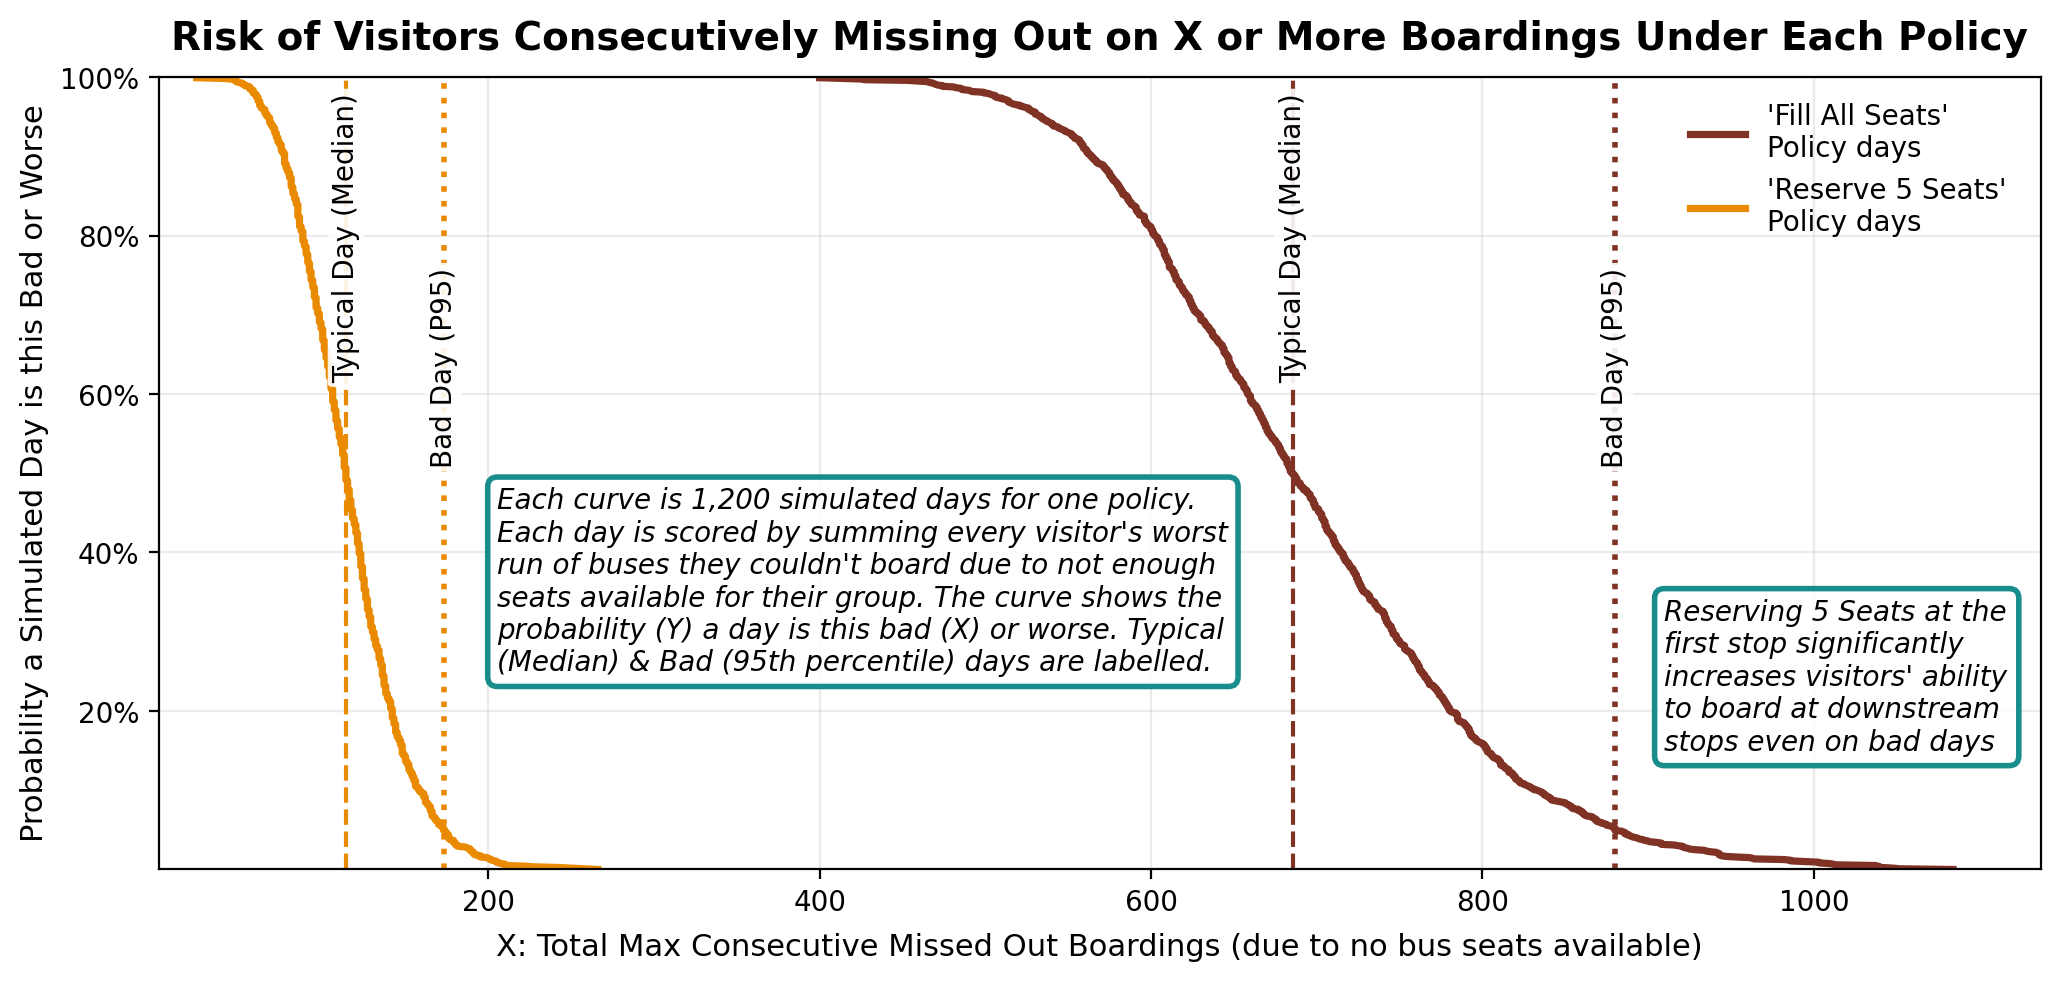

In [17]:
# Plot Exceedance Tail Curve (Survival Function Plot) P(S => x)
plt.figure(figsize=(10.5, 5), dpi=200)
plt.plot(xb, pb, linewidth=2.6, label="'Fill All Seats'\nPolicy days", c=cbase)
plt.plot(xf, pf, linewidth=2.6, label=f"'Reserve {RESERVED} Seats' \nPolicy days", c=cbuff)

plt.ylim(1e-3, 1)   # Adjust y view
plt.grid(True, which="both", axis="both", alpha=0.25)

# Vertical reference lines (median + P95)
plt.axvline(med_b, linestyle="--", linewidth=1.5, c=cbase)
plt.axvline(med_f, linestyle="--", linewidth=1.5, c=cbuff)
plt.axvline(p95_b, linestyle=":",  linewidth=2.0, c=cbase)
plt.axvline(p95_f, linestyle=":",  linewidth=2.0, c=cbuff)

# Annotate markers 
x_off_med = 0.9     # move away from median lines (x units)
x_off_p95 = 0.9     # move away from p95 lines (x units)
y_med_b = 0.92
y_med_f = 0.84
y_p95_b = 0.88
y_p95_f = 0.78

ax = plt.gca()
trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
label_box = dict(boxstyle="round,pad=0.15", facecolor="white", edgecolor="none", alpha=0.9)
# Put labels on the line (x=data), and stack them by y (axes)
plt.text(med_b, 0.98, "Typical Day (Median)",
         transform=trans, rotation=90, va="top", ha="center",
         fontsize=10, bbox=label_box)
plt.text(med_f, 0.98, "Typical Day (Median)",
         transform=trans, rotation=90, va="top", ha="center",
         fontsize=10, bbox=label_box)
plt.text(p95_b, 0.76, "Bad Day (P95)",
         transform=trans, rotation=90, va="top", ha="center",
         fontsize=10, bbox=label_box)
plt.text(p95_f, 0.76, "Bad Day (P95)",
         transform=trans, rotation=90, va="top", ha="center",
         fontsize=10, bbox=label_box)

risk_buf_at_base_p95 = np.mean(scores_buf >= p95_b)
plt.text(
    0.18, 0.25,
    (
    "Each curve is 1,200 simulated days for one policy.\n" 
    "Each day is scored by summing every visitor's worst\n"
    "run of buses they couldn't board due to not enough\n"
    "seats available for their group. The curve shows the\n"
    "probability (Y) a day is this bad (X) or worse. Typical\n"
    "(Median) & Bad (95th percentile) days are labelled."
    ),
    transform=plt.gca().transAxes,
    fontsize=10,
    fontstyle='italic', 
    bbox=dict(boxstyle="round,pad=0.35", facecolor="white", linewidth=2.0, edgecolor="teal", alpha=0.9)
)
plt.text(
    0.80, 0.15,
    f"Reserving 5 Seats at the\n"
    "first stop significantly\n"
    "increases visitors' ability\n"
    "to board at downstream \n"
    "stops even on bad days",
    transform=plt.gca().transAxes,
    fontsize=10,
    fontstyle='italic', 
    bbox=dict(boxstyle="round,pad=0.35", facecolor="white", linewidth=2.0, edgecolor="teal", alpha=0.9)
)

plt.title("Risk of Visitors Consecutively Missing Out on X or More Boardings Under Each Policy", fontsize=14, fontweight='bold', pad=10)
plt.xlabel("X: Total Max Consecutive Missed Out Boardings (due to no bus seats available)", fontsize=11)
plt.ylabel("Probability a Simulated Day is this Bad or Worse", fontsize=11)
plt.legend(frameon=False)
ax = plt.gca()
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))
ax.set_xlim(left=1)  # or left=0.5 etc
ax.xaxis.set_label_coords(0.5, -0.08)

plt.tight_layout()

out = "../Outputs/plot1-exceedance-tail-curve.png"
plt.savefig(out, dpi=300, facecolor="white") 

plt.show()

### ✅ Stacked Bar Chart: Maximum Times a Visitor Couldn't Board Bus Consecutively (No Seats Available)
Downstream Waiting (% of Individual Visitors) of Bad Days by Visitor Group Type - colours by buses skipped band

- For each policy, we show a “bad day” defined as the 95th percentile day from that simulation set. On that day, we plot the maximum number of consecutive buses a visitor group couldn’t board, split by their group size.
- The stacked bars show the proportion of visitor groups whose worst-case consecutive misses were more than 1, comparing the two policies: bus filled at Stop 1 vs holding 5 seats at Stop 1.
- All visitors from all groups size types have their wait times significantly reduced at downstream stops if 5 seats are reserved at the first stop. 
- The plot highlights that larger groups are more likely to experience 5+ consecutive missed buses when the bus is filled at the first stop.


In [25]:
# Functions for Downstream Waiting (% of Individual Visitors) of Bad Days by Visitor Group Type - colours by buses skipped band
STOPS_1TO6 = [1, 2, 3, 4, 5, 6]
BANDS = ["Groups 1-2", "Groups 3-4", "Groups 5+"]

def size_band(sz):
    if sz <= 2: return "Groups 1-2"
    if sz <= 4: return "Groups 3-4"
    return "Groups 5+"

def _get_run(all_runs, run_id):
    return next(r for r in all_runs if r.get("run", None) == run_id)

def _build_run_df(r, stops=STOPS_1TO6):
    df = pd.DataFrame(r["visitor_groups"]).copy()
    df["Band"] = df["Size"].apply(size_band)
    df["MaxConsec"] = df["Max_Consecutive_Skips_By_Stop"].apply(
        lambda d: max(d.get(s, 0) for s in stops)
    )
    return df

# Within band: % of PEOPLE in severity bins (1-2, 3-4, 5+).
def _people_weighted_shares_once_or_more_by_band(df, band):
    d = df[df["Band"] == band].copy()
    total_people = d["Size"].sum()
    if total_people <= 0:
        return {"1-2": 0.0, "3-4": 0.0, "5+": 0.0}
    x = d["MaxConsec"]
    w = d["Size"]
    # Denominator = total people in that band.
    # Bar height = % people with MaxConsec >= 1 (sum of bins).
    p12 = w[x.between(1, 2)].sum() / total_people * 100
    p34 = w[x.between(3, 4)].sum() / total_people * 100
    p5p = w[x.ge(5)].sum()        / total_people * 100
    return {"1-2": float(p12), "3-4": float(p34), "5+": float(p5p)}

# BAD DAY runs
run_bad_base = selected_runs_base["Bad Day (P95)"]["run"]
run_bad_buf  = selected_runs_buf["Bad Day (P95)"]["run"]

df_base_bad = _build_run_df(_get_run(all_runs_baseline, run_bad_base))
df_buf_bad  = _build_run_df(_get_run(all_runs_buffer,   run_bad_buf))

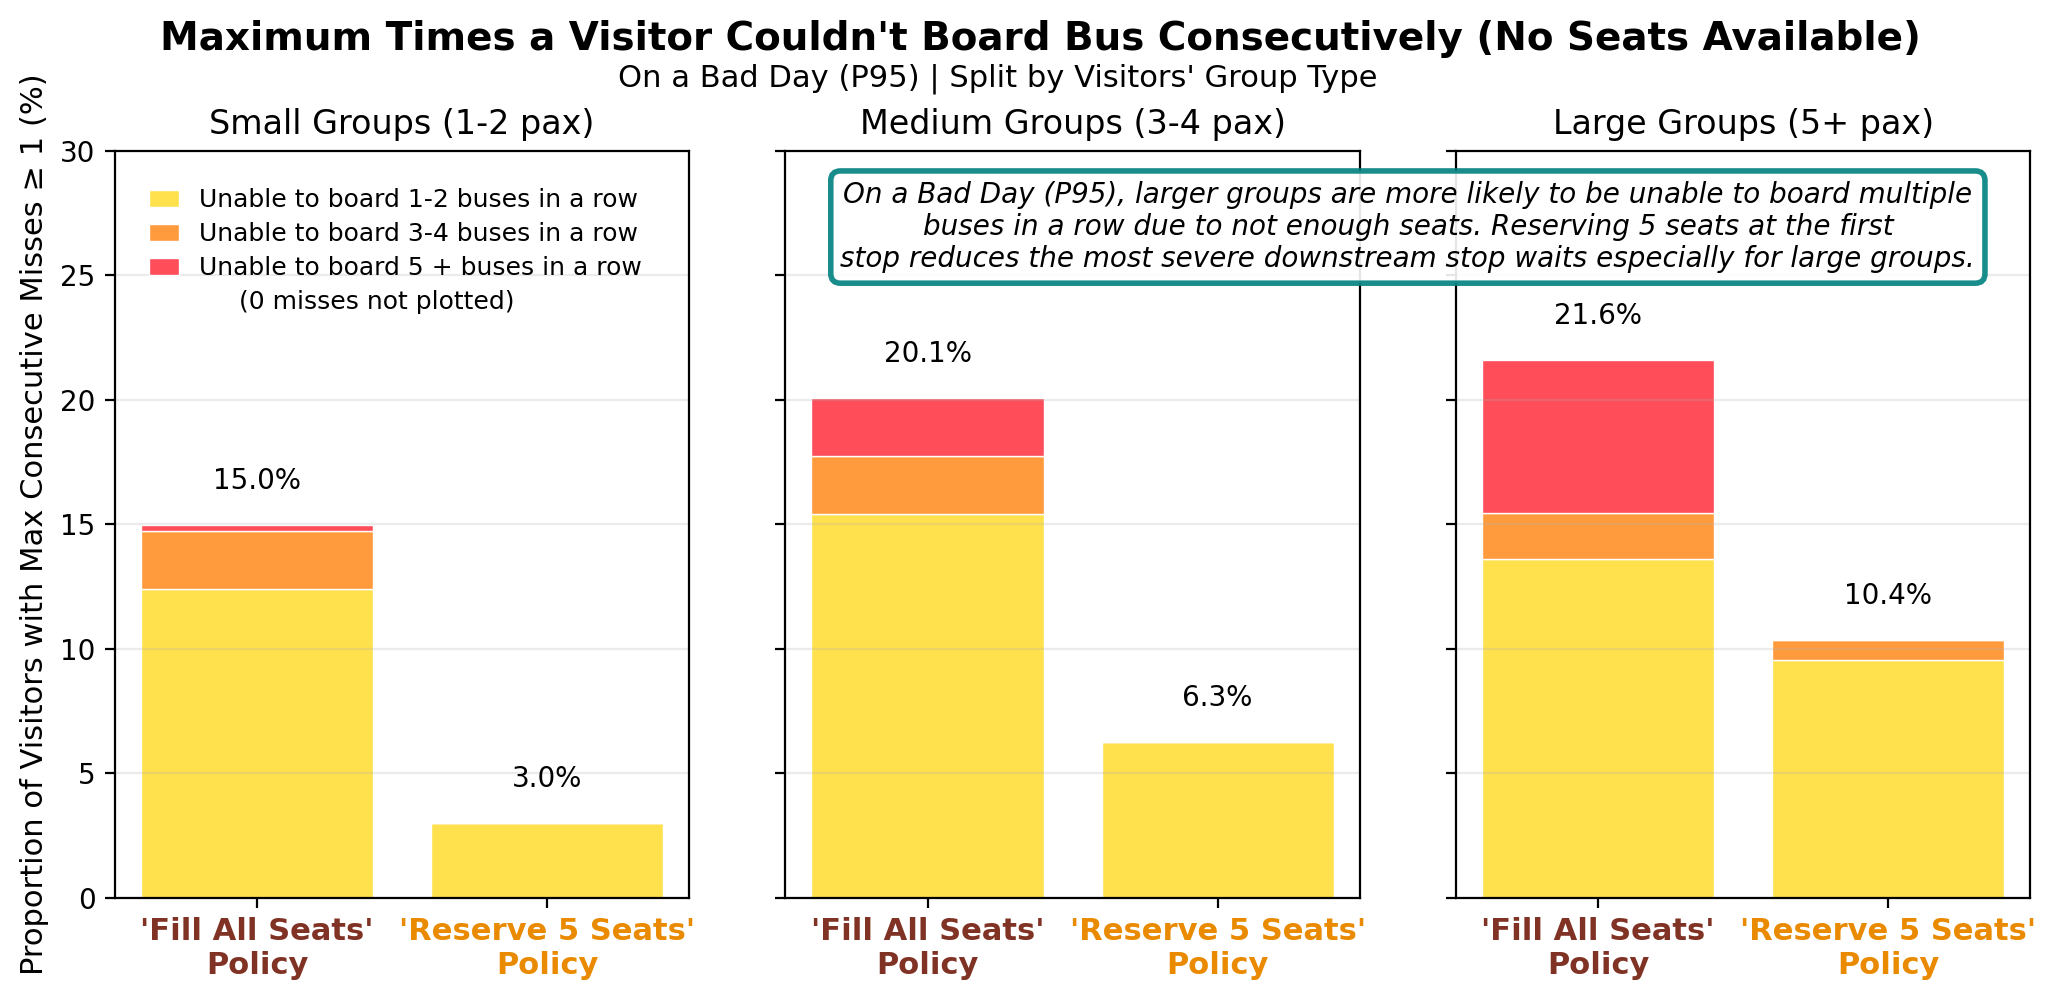

In [26]:
# Plots for Downstream Waiting (% of Individual Visitors) of Bad Days by Visitor Group Type - colours by buses skipped band

# colours: mild -> severe -> extreme
c12 = "#FFE04D"   # lemony yellow 
c34 = "#FF9A3D"   # tangerine orange 
c5p = "#FF4D5A"   # brighter tomato-red 

fig, axes = plt.subplots(1, 3, figsize=(10.5, 5), sharey=True, dpi=200)

BAND_TITLES = {
    "Groups 1-2": "Small Groups (1-2 pax)",
    "Groups 3-4": "Medium Groups (3-4 pax)",
    "Groups 5+":  "Large Groups (5+ pax)",
}

for ax, band in zip(axes, BANDS):
    s_base = _people_weighted_shares_once_or_more_by_band(df_base_bad, band)
    s_buf  = _people_weighted_shares_once_or_more_by_band(df_buf_bad,  band)
    labels = ["'Fill All Seats'\nPolicy", f"'Reserve {RESERVED} Seats'\nPolicy"]
    p12 = np.array([s_base["1-2"], s_buf["1-2"]])
    p34 = np.array([s_base["3-4"], s_buf["3-4"]])
    p5p = np.array([s_base["5+"],  s_buf["5+"]])
    tot = p12 + p34 + p5p
    x = np.arange(2)
    ax.bar(x, p12, color=c12, edgecolor="white", linewidth=0.5, label="Unable to board 1-2 buses in a row" if band == BANDS[0] else None)
    ax.bar(x, p34, bottom=p12, edgecolor="white", linewidth=0.5, color=c34, label="Unable to board 3-4 buses in a row" if band == BANDS[0] else None)
    ax.bar(x, p5p, bottom=p12 + p34, edgecolor="white", linewidth=0.5, color=c5p, label="Unable to board 5 + buses in a row" if band == BANDS[0] else None)
    
    # Top label: total % waited once or more (>=1)
    for i, t in enumerate(tot):
        ax.text(x[i], t + 1.2, f"{t:.1f}%", ha="center", va="bottom", fontsize=10)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=11, fontweight="bold")
    # colour each tick label by policy
    tick_texts = ax.get_xticklabels()
    tick_texts[0].set_color(cbase)  # Baseline
    tick_texts[1].set_color(cbuff)  # Buffer
    ax.set_title(BAND_TITLES.get(band, band), fontsize=12)
    ax.grid(axis="y", alpha=0.25)
    y_cap = 30
    ax.set_ylim(0, y_cap)

axes[0].set_ylabel("Proportion of Visitors with Max Consecutive Misses ≥ 1 (%)", fontsize=11)

fig.suptitle(
    "Maximum Times a Visitor Couldn't Board Bus Consecutively (No Seats Available)",
    fontsize=14,
    y=0.99, 
    fontweight='bold'
)
fig.text(
    0.48, 0.946,  # x, y in figure coords 
    "On a Bad Day (P95) | Split by Visitors' Group Type",
    ha="center", va="top",
    fontsize=11
)
handles, leg_labels = axes[0].get_legend_handles_labels()
handles.append(Patch(facecolor="none", edgecolor="none"))
leg_labels.append("     (0 misses not plotted)")
axes[0].legend(handles, leg_labels, frameon=False, loc="upper left",
               bbox_to_anchor=(0.02, 0.98), fontsize=9,
               handlelength=1.2, labelspacing=0.4)

txt = ("On a Bad Day (P95), larger groups are more likely to be unable to board multiple\n" 
       f"buses in a row due to not enough seats. Reserving {RESERVED} seats at the first\n"
       "stop reduces the most severe downstream stop waits especially for large groups.")
plt.tight_layout()

fig.canvas.draw()
# Get axes positions in figure coords
pos2 = axes[1].get_position()   # panel 2
pos3 = axes[2].get_position()   # panel 3
# Midpoint between panels 2 and 3 (x), and  chosen height (y)
x_mid = (pos2.x1 + pos3.x0) / 2
y_top = pos3.y1 - 0.03         # near the top of panels 
fig.text(
    x_mid, y_top, txt,
    ha="center", va="top",
    fontsize=10, fontstyle="italic",
    bbox=dict(boxstyle="round,pad=0.35", facecolor="white", edgecolor="teal", linewidth=2.0, alpha=0.9)
)
out = "../Outputs/plot2-stacked-bar-chart.png"
fig.savefig(out, dpi=300, facecolor="white") 
plt.show()

#### Media version of Bar Chart

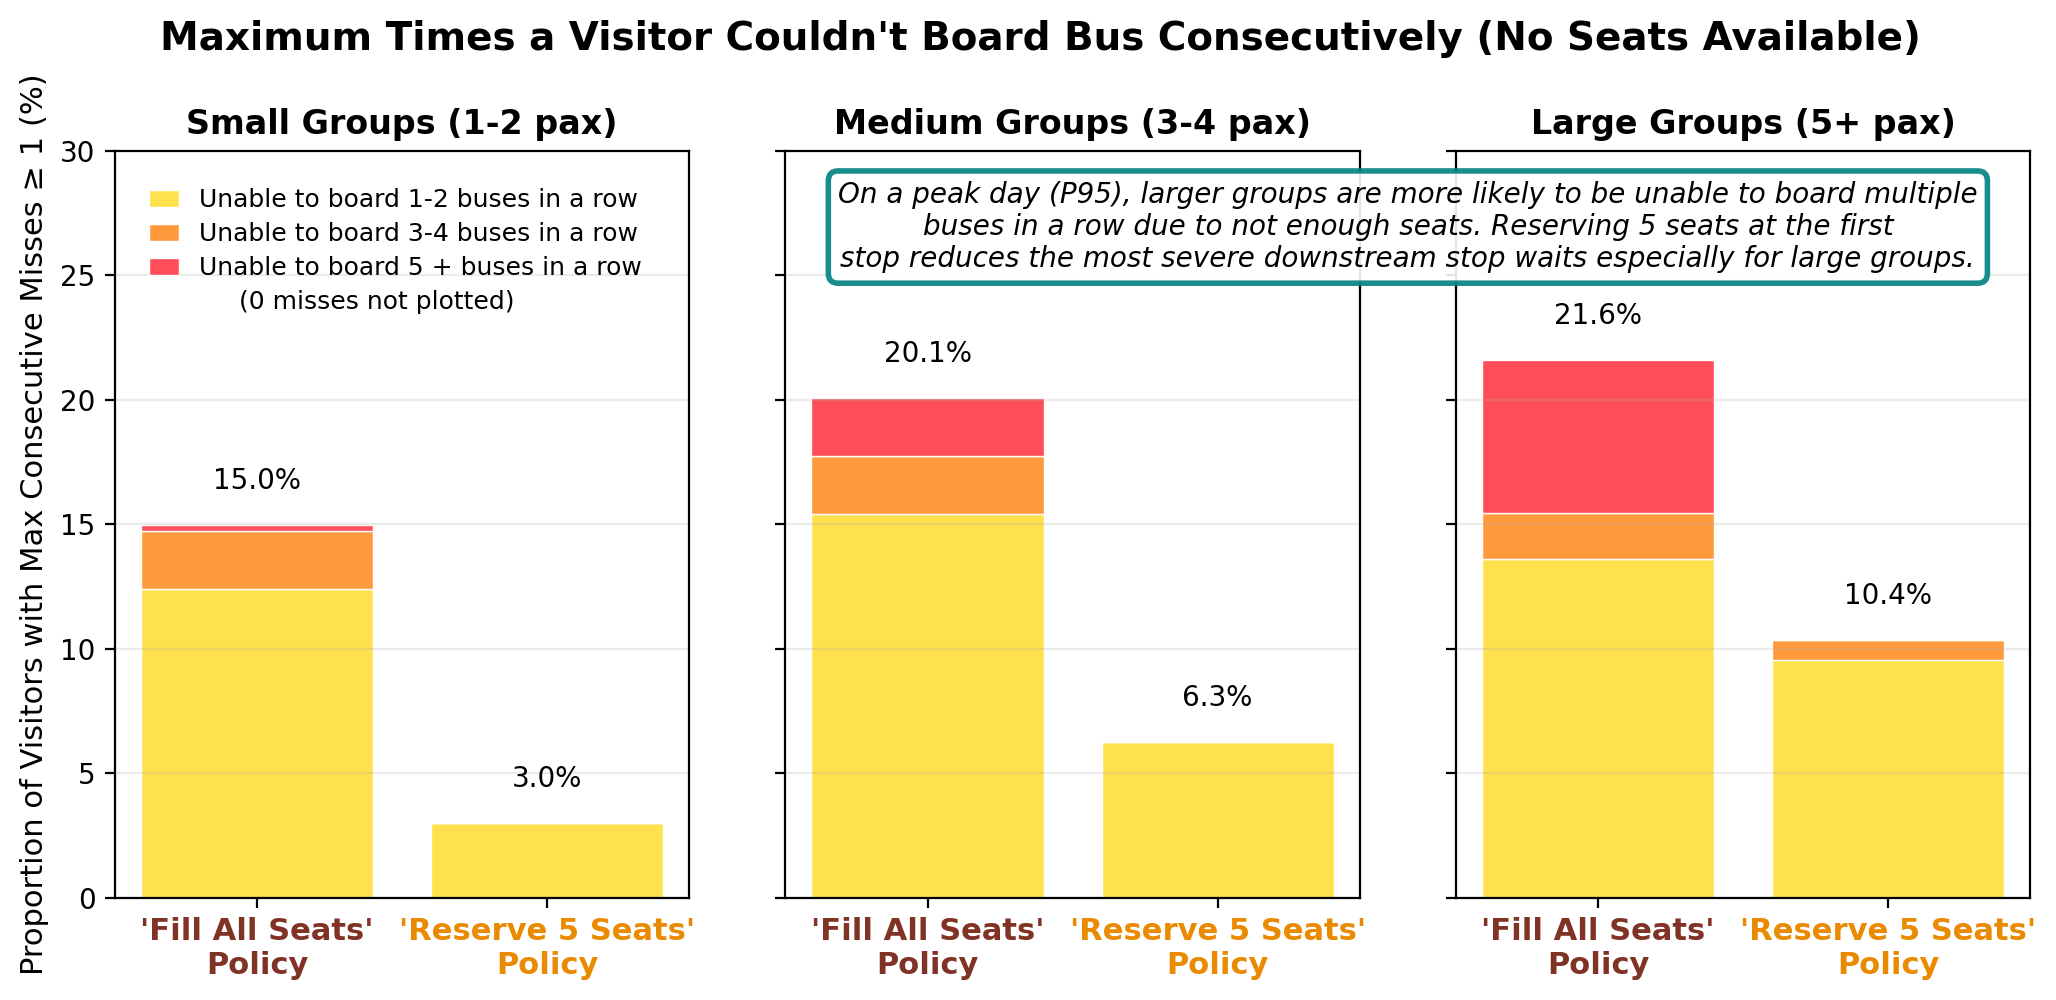

In [24]:
# Plots for Downstream Waiting (% of Individual Visitors) of Bad Days by Visitor Group Type - colours by buses skipped band

# colours: mild -> severe -> extreme
c12 = "#FFE04D"   # lemony yellow 
c34 = "#FF9A3D"   # tangerine orange 
c5p = "#FF4D5A"   # brighter tomato-red 

fig, axes = plt.subplots(1, 3, figsize=(10.5, 5), sharey=True, dpi=200)

BAND_TITLES = {
    "Groups 1-2": "Small Groups (1-2 pax)",
    "Groups 3-4": "Medium Groups (3-4 pax)",
    "Groups 5+":  "Large Groups (5+ pax)",
}

for ax, band in zip(axes, BANDS):
    s_base = _people_weighted_shares_once_or_more_by_band(df_base_bad, band)
    s_buf  = _people_weighted_shares_once_or_more_by_band(df_buf_bad,  band)
    labels = ["'Fill All Seats'\nPolicy", f"'Reserve {RESERVED} Seats'\nPolicy"]
    p12 = np.array([s_base["1-2"], s_buf["1-2"]])
    p34 = np.array([s_base["3-4"], s_buf["3-4"]])
    p5p = np.array([s_base["5+"],  s_buf["5+"]])
    tot = p12 + p34 + p5p
    x = np.arange(2)
    ax.bar(x, p12, color=c12, edgecolor="white", linewidth=0.5, label="Unable to board 1-2 buses in a row" if band == BANDS[0] else None)
    ax.bar(x, p34, bottom=p12, edgecolor="white", linewidth=0.5, color=c34, label="Unable to board 3-4 buses in a row" if band == BANDS[0] else None)
    ax.bar(x, p5p, bottom=p12 + p34, edgecolor="white", linewidth=0.5, color=c5p, label="Unable to board 5 + buses in a row" if band == BANDS[0] else None)
    
    # Top label: total % waited once or more (>=1)
    for i, t in enumerate(tot):
        ax.text(x[i], t + 1.2, f"{t:.1f}%", ha="center", va="bottom", fontsize=10)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=11, fontweight="bold")
    # colour each tick label by policy
    tick_texts = ax.get_xticklabels()
    tick_texts[0].set_color(cbase)  # Baseline
    tick_texts[1].set_color(cbuff)  # Buffer
    ax.set_title(BAND_TITLES.get(band, band), fontsize=12, fontweight="bold")
    ax.grid(axis="y", alpha=0.25)
    y_cap = 30
    ax.set_ylim(0, y_cap)

axes[0].set_ylabel("Proportion of Visitors with Max Consecutive Misses ≥ 1 (%)", fontsize=11)

fig.suptitle(
    "Maximum Times a Visitor Couldn't Board Bus Consecutively (No Seats Available)",
    fontsize=14,
    y=0.99, 
    fontweight='bold'
)
# fig.text(
#     0.48, 0.946,  # x, y in figure coords 
#     "On a Bad Day (P95) | Split by Visitors' Group Type",
#     ha="center", va="top",
#     fontsize=11
# )
handles, leg_labels = axes[0].get_legend_handles_labels()
handles.append(Patch(facecolor="none", edgecolor="none"))
leg_labels.append("     (0 misses not plotted)")
axes[0].legend(handles, leg_labels, frameon=False, loc="upper left",
               bbox_to_anchor=(0.02, 0.98), fontsize=9,
               handlelength=1.2, labelspacing=0.4)

txt = ("On a peak day (P95), larger groups are more likely to be unable to board multiple\n" 
       f"buses in a row due to not enough seats. Reserving {RESERVED} seats at the first\n"
       "stop reduces the most severe downstream stop waits especially for large groups.")
plt.tight_layout()

fig.canvas.draw()
# Get axes positions in figure coords
pos2 = axes[1].get_position()   # panel 2
pos3 = axes[2].get_position()   # panel 3
# Midpoint between panels 2 and 3 (x), and  chosen height (y)
x_mid = (pos2.x1 + pos3.x0) / 2
y_top = pos3.y1 - 0.03         # near the top of panels 
fig.text(
    x_mid, y_top, txt,
    ha="center", va="top",
    fontsize=10, fontstyle="italic",
    bbox=dict(boxstyle="round,pad=0.35", facecolor="white", edgecolor="teal", linewidth=2.0, alpha=0.9)
)
out = "../Outputs_Social_Media/plot2-stacked-bar-chart.png"
fig.savefig(out, dpi=300, facecolor="white") 
plt.show()

### ✅ Radar Chart: Total Visitors Unable to Board by Stop (No Seats Available)

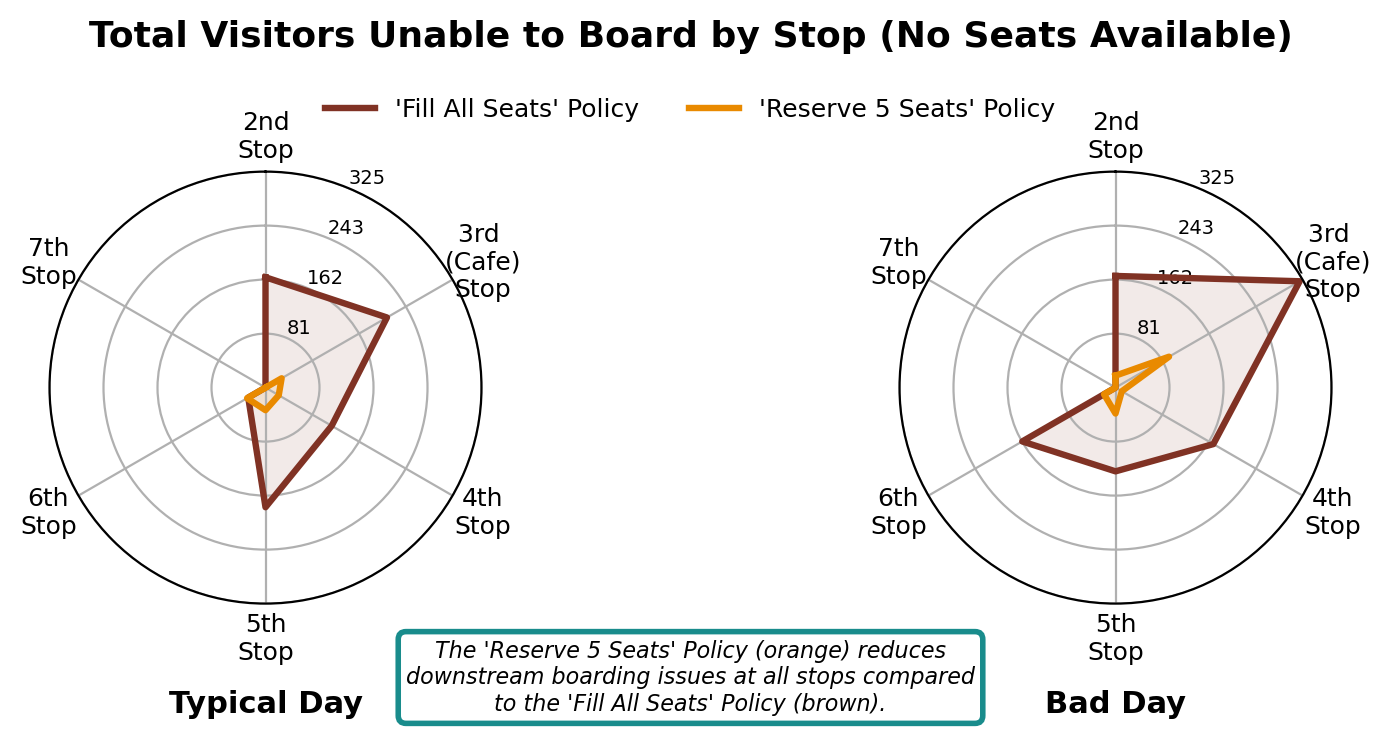

In [20]:
STOPS_1TO6 = [1, 2, 3, 4, 5, 6]

def _get_run(all_runs, run_id):
    return next(r for r in all_runs if r.get("run", None) == run_id)

def _stop_people_refused(all_runs, run_id, stops=STOPS_1TO6):
    r = _get_run(all_runs, run_id)
    d = r.get("stop_refused_people", {})
    return [int(d.get(s, 0)) for s in stops]

def _radar_overlay(ax, labels, vals_base, vals_buf, rmax, col_base, col_buf):
    n = len(labels)
    angles = np.linspace(0, 2*np.pi, n, endpoint=False).tolist()
    angles += angles[:1]

    vb = list(vals_base) + [vals_base[0]]
    vf = list(vals_buf)  + [vals_buf[0]]

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Pull category labels inward a bit
    ax.tick_params(axis="x", pad=2)
    # Baseline
    ax.plot(angles, vb, linewidth=2.3, color=col_base, label="'Fill All Seats' Policy")
    ax.fill(angles, vb, alpha=0.10, color=col_base)
    # Buffer
    ax.plot(angles, vf, linewidth=2.3, color=col_buf, label=f"'Reserve {RESERVED} Seats' Policy")
    ax.fill(angles, vf, alpha=0.10, color=col_buf)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=9)
    ax.set_ylim(0, rmax)

    ring_steps = 4
    yticks = np.linspace(0, rmax, ring_steps + 1)[1:]
    ax.set_yticks(yticks)
    ax.set_yticklabels([f"{int(t):,}" for t in yticks], fontsize=7)

downstream_labels = {
    1: "2nd",
    2: "3rd \n(Cafe)",
    3: "4th",
    4: "5th",
    5: "6th",
    6: "7th",
}
labels = [f"{downstream_labels[s]}\nStop" for s in STOPS_1TO6]

# Selected runs
typ_base = selected_runs_base["Typical Day (Median)"]["run"]
bad_base = selected_runs_base["Bad Day (P95)"]["run"]
typ_buf  = selected_runs_buf["Typical Day (Median)"]["run"]
bad_buf  = selected_runs_buf["Bad Day (P95)"]["run"]

typ_vals_base = _stop_people_refused(all_runs_baseline, typ_base)
typ_vals_buf  = _stop_people_refused(all_runs_buffer,   typ_buf)
bad_vals_base = _stop_people_refused(all_runs_baseline, bad_base)
bad_vals_buf  = _stop_people_refused(all_runs_buffer,   bad_buf)

# Shared radial scale
rmax = max(typ_vals_base + typ_vals_buf + bad_vals_base + bad_vals_buf)
nice = 10 if rmax < 200 else 25 if rmax < 600 else 50
rmax = int(np.ceil(rmax / nice) * nice)


# Plot: centred axes + titles below
fig, axes = plt.subplots(
    1, 2,
    figsize=(10, 4),
    subplot_kw=dict(polar=True),
    dpi=200
)

_radar_overlay(axes[0], labels, typ_vals_base, typ_vals_buf, rmax, cbase, cbuff)
_radar_overlay(axes[1], labels, bad_vals_base, bad_vals_buf, rmax, cbase, cbuff)

# Centre the two radars nicely and keep them the same size
left_margin  = 0.10
right_margin = 0.10
gap          = 0.05      # space between the two radars
bottom       = 0.24
height       = 0.54
usable_w = 1 - left_margin - right_margin
w = (usable_w - gap) / 2
axes[0].set_position([left_margin,            bottom, w, height])
axes[1].set_position([left_margin + w + gap,  bottom, w, height])

# Titles BELOW each radar (use axes coords, y < 0)
axes[0].text(
    0.5, -0.20,
    "Typical Day",
    transform=axes[0].transAxes,
    ha="center", va="top",
    fontsize=11, fontweight="bold"
)
axes[1].text(
    0.5, -0.20,
    "Bad Day",
    transform=axes[1].transAxes,
    ha="center", va="top",
    fontsize=11, fontweight="bold"
)
# Main title 
fig.suptitle(
    "Total Visitors Unable to Board by Stop (No Seats Available)",
    fontsize=13,
    fontweight="bold",
    y=0.97
)

note = (
    f"The 'Reserve {RESERVED} Seats' Policy (orange) reduces"
    "\ndownstream boarding issues at all stops compared\n"
    "to the 'Fill All Seats' Policy (brown)."
)

fig.text(
    0.5, 0.10,                       # centred, near bottom (adjust 0.05 if needed)
    note,
    ha="center", va="bottom",
    fontsize=8,
    fontstyle="italic",
    bbox=dict(
        boxstyle="round,pad=0.35",
        facecolor="white",
        linewidth=2.0,
        edgecolor="teal",
        alpha=0.9
    )
)
# Legend (top centre)
handles, leg_labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, leg_labels,
    frameon=False,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.90),
    ncol=2,
    fontsize=9
)
out = "../Outputs/plot3-radar.png"
fig.savefig(out, dpi=300, bbox_inches="tight", facecolor="white") 
plt.show()

#### Media version of Radar

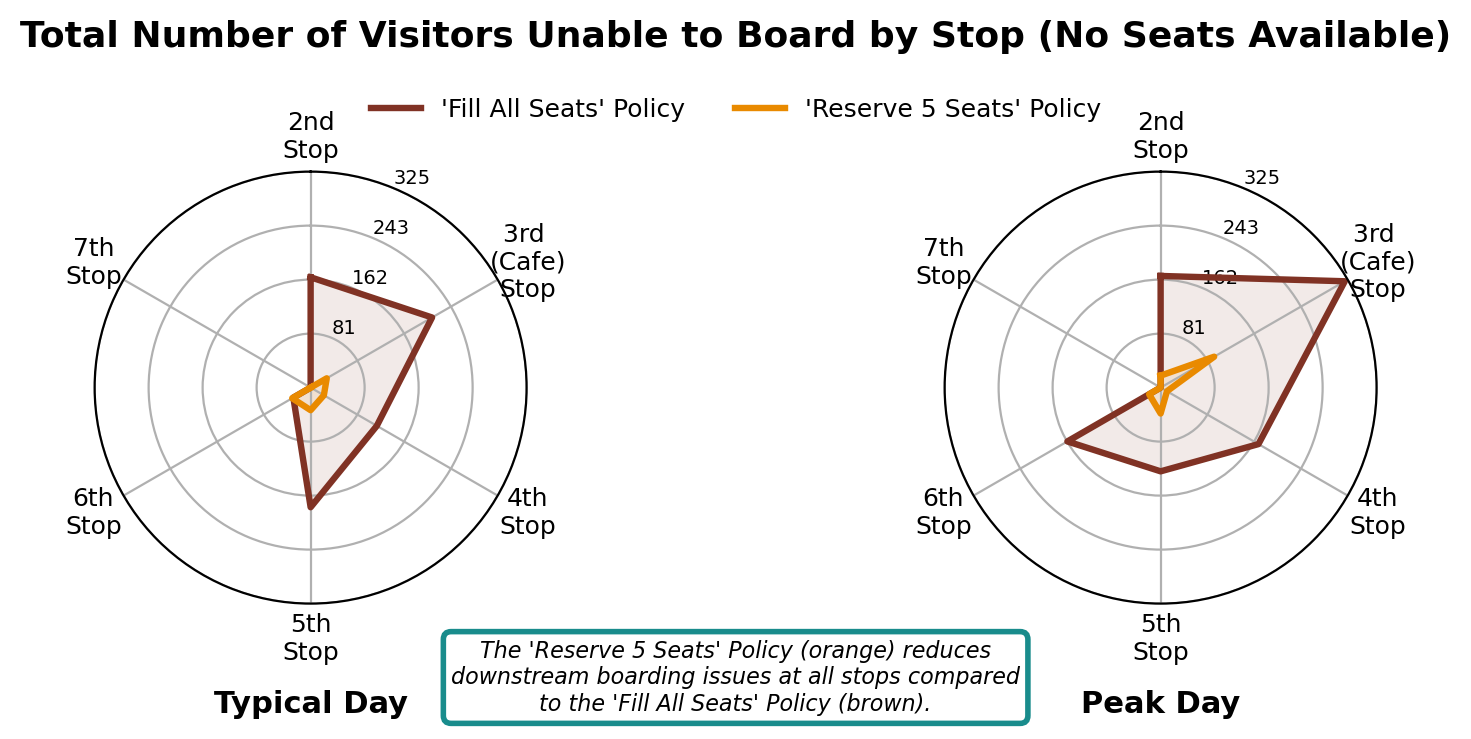

In [27]:
STOPS_1TO6 = [1, 2, 3, 4, 5, 6]

def _get_run(all_runs, run_id):
    return next(r for r in all_runs if r.get("run", None) == run_id)

def _stop_people_refused(all_runs, run_id, stops=STOPS_1TO6):
    r = _get_run(all_runs, run_id)
    d = r.get("stop_refused_people", {})
    return [int(d.get(s, 0)) for s in stops]

def _radar_overlay(ax, labels, vals_base, vals_buf, rmax, col_base, col_buf):
    n = len(labels)
    angles = np.linspace(0, 2*np.pi, n, endpoint=False).tolist()
    angles += angles[:1]

    vb = list(vals_base) + [vals_base[0]]
    vf = list(vals_buf)  + [vals_buf[0]]

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Pull category labels inward a bit
    ax.tick_params(axis="x", pad=2)
    # Baseline
    ax.plot(angles, vb, linewidth=2.3, color=col_base, label="'Fill All Seats' Policy")
    ax.fill(angles, vb, alpha=0.10, color=col_base)
    # Buffer
    ax.plot(angles, vf, linewidth=2.3, color=col_buf, label=f"'Reserve {RESERVED} Seats' Policy")
    ax.fill(angles, vf, alpha=0.10, color=col_buf)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=9)
    ax.set_ylim(0, rmax)

    ring_steps = 4
    yticks = np.linspace(0, rmax, ring_steps + 1)[1:]
    ax.set_yticks(yticks)
    ax.set_yticklabels([f"{int(t):,}" for t in yticks], fontsize=7)

downstream_labels = {
    1: "2nd",
    2: "3rd \n(Cafe)",
    3: "4th",
    4: "5th",
    5: "6th",
    6: "7th",
}
labels = [f"{downstream_labels[s]}\nStop" for s in STOPS_1TO6]

# Selected runs
typ_base = selected_runs_base["Typical Day (Median)"]["run"]
bad_base = selected_runs_base["Bad Day (P95)"]["run"]
typ_buf  = selected_runs_buf["Typical Day (Median)"]["run"]
bad_buf  = selected_runs_buf["Bad Day (P95)"]["run"]

typ_vals_base = _stop_people_refused(all_runs_baseline, typ_base)
typ_vals_buf  = _stop_people_refused(all_runs_buffer,   typ_buf)
bad_vals_base = _stop_people_refused(all_runs_baseline, bad_base)
bad_vals_buf  = _stop_people_refused(all_runs_buffer,   bad_buf)

# Shared radial scale
rmax = max(typ_vals_base + typ_vals_buf + bad_vals_base + bad_vals_buf)
nice = 10 if rmax < 200 else 25 if rmax < 600 else 50
rmax = int(np.ceil(rmax / nice) * nice)


# Plot: centred axes + titles below
fig, axes = plt.subplots(
    1, 2,
    figsize=(10, 4),
    subplot_kw=dict(polar=True),
    dpi=200
)

_radar_overlay(axes[0], labels, typ_vals_base, typ_vals_buf, rmax, cbase, cbuff)
_radar_overlay(axes[1], labels, bad_vals_base, bad_vals_buf, rmax, cbase, cbuff)

# Centre the two radars nicely and keep them the same size
left_margin  = 0.10
right_margin = 0.10
gap          = 0.05      # space between the two radars
bottom       = 0.24
height       = 0.54
usable_w = 1 - left_margin - right_margin
w = (usable_w - gap) / 2
axes[0].set_position([left_margin,            bottom, w, height])
axes[1].set_position([left_margin + w + gap,  bottom, w, height])

# Titles BELOW each radar (use axes coords, y < 0)
axes[0].text(
    0.5, -0.20,
    "Typical Day",
    transform=axes[0].transAxes,
    ha="center", va="top",
    fontsize=11, fontweight="bold"
)
axes[1].text(
    0.5, -0.20,
    "Peak Day",
    transform=axes[1].transAxes,
    ha="center", va="top",
    fontsize=11, fontweight="bold"
)
# Main title 
fig.suptitle(
    "Total Number of Visitors Unable to Board by Stop (No Seats Available)",
    fontsize=13,
    fontweight="bold",
    y=0.97
)

note = (
    f"The 'Reserve {RESERVED} Seats' Policy (orange) reduces"
    "\ndownstream boarding issues at all stops compared\n"
    "to the 'Fill All Seats' Policy (brown)."
)

fig.text(
    0.5, 0.10,                       # centred, near bottom (adjust 0.05 if needed)
    note,
    ha="center", va="bottom",
    fontsize=8,
    fontstyle="italic",
    bbox=dict(
        boxstyle="round,pad=0.35",
        facecolor="white",
        linewidth=2.0,
        edgecolor="teal",
        alpha=0.9
    )
)
# Legend (top centre)
handles, leg_labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, leg_labels,
    frameon=False,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.90),
    ncol=2,
    fontsize=9
)
out = "../Outputs_Social_Media/plot3-radar.png"
fig.savefig(out, dpi=300, bbox_inches="tight", facecolor="white") 
plt.show()